## Smooth Velocity Model (Supervised Learning)

#### Table of Contents
<ul>
<li><a href="#lib">Necessary Libraries<a/></li>
<li><a href="#gpu">GPU Setting & Code Reproducibility<a/></li>
<li><a href="#model">Smooth Velocity Model<a/></li>
<li><a href="#analytical">Analytical Solution<a/></li>
<li><a href="#test">All Data Points<a/></li>
<li><a href="#train">Selected Data Points<a/></li>
<li><a href="#archi">Network Architecture & Random Initialisation<a/></li>
<li><a href="#tau">Neural Network<a/></li>
<li><a href="#other">MSE Loss<a/></li>
<li><a href="#comnbine">Combined Loss Function<a/></li>
<li><a href="#training">Model Training (All Data Points)<a/></li>
<li><a href="#tau_pred">Model Training (Selected Data Points)<a/></li>

<a id="lib"></a>
#### Necessary Libraries

In [1]:
# Jax Libraries
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import optax
import pickle
from jax.lib import xla_bridge

# Data Visualisation Libraries
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import timeit

# Operating System and gpu
import os 
import subprocess

<a id="gpu"></a>
#### GPU Setting & Code Reproducibility

In [2]:
# Displays if the notebook currently has access to a gpu
print(f"This Notebook is currently running on a: {(xla_bridge.get_backend().platform)}")

# Assigns a specific GPU to be used
GPU = 0
os.environ['CUDA_VISIBLE_DEVICES'] = 'GPU'

# Displays the GPU details used for the notebook execution
output = subprocess.check_output(['nvidia-smi', '-L']).decode('utf-8')
gpu_info = output.strip().split('\n')
print(gpu_info[GPU])

# Defines a random key to be employed using seed 0
random_key = random.PRNGKey(0)

This Notebook is currently running on a: gpu
GPU 0: NVIDIA RTX A5000 (UUID: GPU-8b9362c6-1305-75bd-e211-a767d8b39a65)


<a id="model"></a>
#### Smooth Velocity Model

In [3]:
# Velocity at origin
v0 = 2 

# Vertical axis
z_grad = 0.5; z_min = 0.; z_max = 2; z_delta = 0.02

# Horizontal axis
x_grad = 0.0; x_min = 0.0; x_max = 2; x_delta = 0.02

# Point-source location
sz = 1.0; sx = 1.0;

# Number of training points
training_points = 2500

In [4]:
# Generating the vertical and horizontal values of our model
z = jnp.arange(z_min,z_max+z_delta,z_delta)
x = jnp.arange(x_min,x_max+x_delta,x_delta)

In [5]:
Z,X = jnp.meshgrid(z,x,indexing='ij')

In [6]:
# Preparing velocity model
vs = v0 + z_grad*sz + x_grad*sx # Velocity at source location
velmodel = vs + z_grad*(Z-sz) + x_grad*(X-sx);

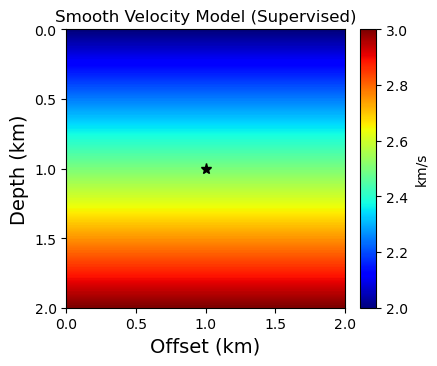

In [7]:
# Model with the source location

plt.style.use('default')         # Sets the default style for the plot

plt.figure(figsize=(4,4))        # Creates a new figure with a size of 4x4 inches

plt.title("Smooth Velocity Model (Supervised)")    # Sets the title of the figure

ax = plt.gca()                   # Gets the current axes instance.
im = ax.imshow(velmodel, extent=[x_min,x_max,z_max,z_min], aspect=1, cmap="jet") # Plots the velocity model velmodel as an image on the current axes (ax)

ax.plot(sx,sz,'k*',markersize=8) # Plots a black star marker at the source location 

plt.xlabel('Offset (km)', fontsize=14)     # Sets the label for the x-axis
plt.xticks(fontsize=10)          # Sets the font size for the x-axis tick labels

plt.ylabel('Depth (km)', fontsize=14)      # Sets the label for the y-axis
plt.yticks(fontsize=10)          # Sets the font size for the y-axis tick labels

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the major tick locator for the x-axis to have ticks at intervals of 0.5.
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the major tick locator for the y-axis to have ticks at intervals of 0.5.

divider = make_axes_locatable(ax)         # Creates a divider to make room for the colorbar
cax = divider.append_axes("right", size="6%", pad=0.15) # Appends an axes on the right side of the plot to accommodate the colorbar

cbar = plt.colorbar(im, cax=cax) # Adds a colorbar to the plot using the image im and the colorbar axes cax

cbar.set_label('km/s',size=10)   # Sets the label for the colorbar.
cbar.ax.tick_params(labelsize=10)        # Sets the font size of the colorbar tick labels.

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Smooth Velocity (Supervised) Model.pdf", format= "pdf",bbox_inches="tight")  # Saves the image as a pdf file at the specified file directory

plt.show()   # Displays the defined image

<a id="analytical"></a>
#### Analytical Solution

In [8]:
# Traveltime solution

if z_grad==0 and x_grad==0: 
  # Homogeneous velocity model
  T_data = jnp.sqrt((Z-sz)**2 + (X-sx)**2)/v0;
else: 
  # Velocity gradient model
  T_data = jnp.arccosh(1.0+0.5*(1.0/velmodel)*(1/vs)*(z_grad**2 + x_grad**2)*((X-sx)**2 + (Z-sz)**2))/jnp.sqrt(z_grad**2 + x_grad**2)

In [9]:
# Analytical Parameters for testing
vel = velmodel[int(round(sz/z_delta)),int(round(sx/x_delta))] # Velocity at the source location

T0 = jnp.sqrt((Z-sz)**2 + (X-sx)**2)/vel; #  Calculates the travel time T0 for each point in the grid

px0 = jnp.where(T0 != 0, jnp.divide(X - sx, T0 * vel**2), 0)  # Calculates the x-component of the vector 

pz0 = jnp.where(T0 != 0, jnp.divide(Z - sz, T0 * vel**2), 0)  # Calculates the y-component of the vector 

<a id="test"></a>
#### All Data Points

In [10]:
# Grid points for testing 
X_star = [Z.reshape(-1,1), X.reshape(-1,1)]

In [11]:
# Declares the correct solution for the entire dataset
true_tau = jnp.where(T0 != 0, jnp.divide(T_data, T0), 0)
true_tau = true_tau.reshape(-1,1)

<a id="train"></a>
#### Selected Data Points

In [12]:
# Saves 2500 randomly selected points
selected_points = random.choice(random_key, jnp.arange(Z.size), shape=(training_points,), replace=False)

In [13]:
# Z and X Values for training
Zf = Z.reshape(-1,1)[selected_points] # selects the 2500 points from Zf
Zf = jnp.append(Zf,sz)                # Appends the source location to the selected points for Zf
Xf = X.reshape(-1,1)[selected_points] # selects the 2500 points from Xf
Xf = jnp.append(Xf,sx)                # Appends the source location to the selected points for Xf

In [14]:
# Grid points for training
X_starf = [Zf.reshape(-1,1), Xf.reshape(-1,1)]

In [15]:
# Preparing Training data
velmodelf = velmodel.reshape(-1,1)[selected_points]; velmodelf = jnp.append(velmodelf,vs)   # selects the 2500 points from velmodel and appends the velocity at source location
px0f = px0.reshape(-1,1)[selected_points]; px0f = jnp.append(px0f,0.)    # selects the 2500 points from px0 and appends the value at source location
pz0f = pz0.reshape(-1,1)[selected_points]; pz0f = jnp.append(pz0f,0.)    # selects the 2500 points from pz0 and appends the value at source location
T0f = T0.reshape(-1,1)[selected_points]; T0f = jnp.append(T0f,0.)        # selects the 2500 points from T0 and appends the value at source location

In [16]:
# declares the correct tau solutions for the selected points
sel_T_data =  jnp.where(T0 != 0, jnp.divide(T_data, T0), 0)
true_tau_f = sel_T_data.reshape(-1,1)[selected_points]
true_tau_f  = jnp.append(true_tau,0)

<a id="archi"></a>
#### Network Architecture & Random Initialisation

In [17]:
# Architecture of the neural network model
layers = [2,20,20,20,20,20,20,20,20,20,20,1]  

In [18]:
# Function to randomly initialise the network parameters using Xavier iniatialisation
def init_params(layers):

  keys = jax.random.split(jax.random.PRNGKey(0),len(layers)-1)
  params = list()      # Defines an empty list to store the parameters

  for key,n_in,n_out in zip(keys,layers[:-1],layers[1:]):   # For loop iterates over the keys, number of input neurons (n_in), and number of output neurons 
    lb = -(1 / jnp.sqrt(n_in)) # lower bound
    ub = (1 / jnp.sqrt(n_in)) # upper bound
    W = lb + (ub-lb) * jax.random.uniform(key,shape=(n_in,n_out))  # Initialises the weight matrix
    B = jax.random.uniform(key,shape=(n_out,))             # Initialises the bias vector 
    params.append({'W':W,'B':B})                           # Adds a dictionary containing the weight matrix W and bias vector B to the params list
  return params        # Returns the initialised parameters

In [19]:
# Initialises the parameters of the neural network based on the specified layer architecture.
params = init_params(layers)

<a id="tau"></a>
#### Neural Network

In [20]:
# Function tau to computes the output of the neural network 
def tau(params,zt,xt):

  X = jnp.concatenate([zt,xt],axis=1)

  *hidden,last = params
  for layer in hidden:

    X = jax.nn.tanh(X@layer['W']+layer['B']) # Applying the hyperbolic tangent (tanh) activation function

  return X@last['W'] + last['B'] 

<a id="other"></a>
#### MSE Losses

In [21]:
@jax.jit    # Just-in-Time (JIT) decorator to accelerate computation
def MSE(true_tau,pred_tau):
    # Function to compute mean squared error (MSE)
    
    return jnp.mean((true_tau-pred_tau)**2)  # Computes and returns the MSE between true and pred

<a id="combine"></a>
#### Combined Loss Function

In [22]:
@jax.jit    # Just-in-Time (JIT) decorator to accelerate computation
def loss_fun(params,true_tau,X_starf):
  xt = X_star[1]
  zt = X_star[0]

  pred_tau = tau(params,zt,xt)

  loss = MSE(true_tau, pred_tau)

  return loss

<a id="training"></a>
#### Model Training (All Data Points)

In [23]:
# defines an adaptive learning rate that changes at specified epochs
lr = optax.piecewise_constant_schedule(1e-2,{500:2.9e-3})

# Utilises the adam optimiser
optimizer = optax.adam(lr)

# Updates the parameters
opt_state = optimizer.init(params)

In [24]:
@jax.jit    # Just-in-Time (JIT) decorator to accelerate computation
def update(opt_state,params,X_starf,true_tau):
    # Function to update the parameters for each gradient descent
    
    # calculates the gradients of loss_fun
    grads=jax.grad(loss_fun,0)(params,X_starf,true_tau)

    # Update params
    updates, opt_state = optimizer.update(grads, opt_state)
    
    # Applies the updated params
    params = optax.apply_updates(params, updates)

    return opt_state,params

In [25]:
%%time
epochs = 12000 
loss_value = [] # List to hold the values of the combines loss

for epoch in range(epochs):  # For loop to iterate over the stipulates epochs
    opt_state, params = update(opt_state,params,true_tau,X_star)

    # print loss and epoch info
    if epoch%(1) ==0:
        loss_pp = loss_fun(params,true_tau,X_star) # Computes the total loss
        loss_value.append(loss_pp)                                    # Appends the total loss value to the declared list
        print(f'Epoch = {epoch},\tloss = {loss_pp:.3e}')              # Prints the total loss values for each epoch

Epoch = 0,	loss = 3.884e-02
Epoch = 1,	loss = 4.554e-02
Epoch = 2,	loss = 8.768e-03
Epoch = 3,	loss = 9.442e-03
Epoch = 4,	loss = 2.590e-02
Epoch = 5,	loss = 2.067e-02
Epoch = 6,	loss = 7.297e-03
Epoch = 7,	loss = 4.006e-03
Epoch = 8,	loss = 1.020e-02
Epoch = 9,	loss = 1.431e-02
Epoch = 10,	loss = 1.126e-02
Epoch = 11,	loss = 5.718e-03
Epoch = 12,	loss = 3.611e-03
Epoch = 13,	loss = 5.880e-03
Epoch = 14,	loss = 8.751e-03
Epoch = 15,	loss = 8.724e-03
Epoch = 16,	loss = 6.155e-03
Epoch = 17,	loss = 3.892e-03
Epoch = 18,	loss = 3.907e-03
Epoch = 19,	loss = 5.520e-03
Epoch = 20,	loss = 6.539e-03
Epoch = 21,	loss = 5.852e-03
Epoch = 22,	loss = 4.363e-03
Epoch = 23,	loss = 3.590e-03
Epoch = 24,	loss = 4.025e-03
Epoch = 25,	loss = 4.896e-03
Epoch = 26,	loss = 5.182e-03
Epoch = 27,	loss = 4.635e-03
Epoch = 28,	loss = 3.862e-03
Epoch = 29,	loss = 3.588e-03
Epoch = 30,	loss = 3.935e-03
Epoch = 31,	loss = 4.394e-03
Epoch = 32,	loss = 4.434e-03
Epoch = 33,	loss = 4.044e-03
Epoch = 34,	loss = 3.652

Epoch = 464,	loss = 9.816e-05
Epoch = 465,	loss = 9.816e-05
Epoch = 466,	loss = 9.816e-05
Epoch = 467,	loss = 9.816e-05
Epoch = 468,	loss = 9.815e-05
Epoch = 469,	loss = 9.815e-05
Epoch = 470,	loss = 9.815e-05
Epoch = 471,	loss = 9.815e-05
Epoch = 472,	loss = 9.815e-05
Epoch = 473,	loss = 9.815e-05
Epoch = 474,	loss = 9.815e-05
Epoch = 475,	loss = 9.815e-05
Epoch = 476,	loss = 9.815e-05
Epoch = 477,	loss = 9.815e-05
Epoch = 478,	loss = 9.814e-05
Epoch = 479,	loss = 9.814e-05
Epoch = 480,	loss = 9.814e-05
Epoch = 481,	loss = 9.814e-05
Epoch = 482,	loss = 9.814e-05
Epoch = 483,	loss = 9.814e-05
Epoch = 484,	loss = 9.814e-05
Epoch = 485,	loss = 9.814e-05
Epoch = 486,	loss = 9.814e-05
Epoch = 487,	loss = 9.814e-05
Epoch = 488,	loss = 9.814e-05
Epoch = 489,	loss = 9.814e-05
Epoch = 490,	loss = 9.813e-05
Epoch = 491,	loss = 9.813e-05
Epoch = 492,	loss = 9.813e-05
Epoch = 493,	loss = 9.813e-05
Epoch = 494,	loss = 9.813e-05
Epoch = 495,	loss = 9.813e-05
Epoch = 496,	loss = 9.813e-05
Epoch = 49

Epoch = 942,	loss = 9.813e-05
Epoch = 943,	loss = 9.813e-05
Epoch = 944,	loss = 9.813e-05
Epoch = 945,	loss = 9.813e-05
Epoch = 946,	loss = 9.813e-05
Epoch = 947,	loss = 9.813e-05
Epoch = 948,	loss = 9.813e-05
Epoch = 949,	loss = 9.813e-05
Epoch = 950,	loss = 9.813e-05
Epoch = 951,	loss = 9.813e-05
Epoch = 952,	loss = 9.813e-05
Epoch = 953,	loss = 9.813e-05
Epoch = 954,	loss = 9.813e-05
Epoch = 955,	loss = 9.813e-05
Epoch = 956,	loss = 9.813e-05
Epoch = 957,	loss = 9.813e-05
Epoch = 958,	loss = 9.813e-05
Epoch = 959,	loss = 9.813e-05
Epoch = 960,	loss = 9.813e-05
Epoch = 961,	loss = 9.813e-05
Epoch = 962,	loss = 9.813e-05
Epoch = 963,	loss = 9.813e-05
Epoch = 964,	loss = 9.813e-05
Epoch = 965,	loss = 9.813e-05
Epoch = 966,	loss = 9.813e-05
Epoch = 967,	loss = 9.813e-05
Epoch = 968,	loss = 9.813e-05
Epoch = 969,	loss = 9.813e-05
Epoch = 970,	loss = 9.813e-05
Epoch = 971,	loss = 9.813e-05
Epoch = 972,	loss = 9.813e-05
Epoch = 973,	loss = 9.813e-05
Epoch = 974,	loss = 9.813e-05
Epoch = 97

Epoch = 1422,	loss = 9.812e-05
Epoch = 1423,	loss = 9.812e-05
Epoch = 1424,	loss = 9.812e-05
Epoch = 1425,	loss = 9.812e-05
Epoch = 1426,	loss = 9.812e-05
Epoch = 1427,	loss = 9.812e-05
Epoch = 1428,	loss = 9.812e-05
Epoch = 1429,	loss = 9.812e-05
Epoch = 1430,	loss = 9.812e-05
Epoch = 1431,	loss = 9.812e-05
Epoch = 1432,	loss = 9.812e-05
Epoch = 1433,	loss = 9.812e-05
Epoch = 1434,	loss = 9.812e-05
Epoch = 1435,	loss = 9.812e-05
Epoch = 1436,	loss = 9.812e-05
Epoch = 1437,	loss = 9.812e-05
Epoch = 1438,	loss = 9.812e-05
Epoch = 1439,	loss = 9.812e-05
Epoch = 1440,	loss = 9.812e-05
Epoch = 1441,	loss = 9.812e-05
Epoch = 1442,	loss = 9.812e-05
Epoch = 1443,	loss = 9.812e-05
Epoch = 1444,	loss = 9.812e-05
Epoch = 1445,	loss = 9.812e-05
Epoch = 1446,	loss = 9.812e-05
Epoch = 1447,	loss = 9.812e-05
Epoch = 1448,	loss = 9.812e-05
Epoch = 1449,	loss = 9.812e-05
Epoch = 1450,	loss = 9.812e-05
Epoch = 1451,	loss = 9.812e-05
Epoch = 1452,	loss = 9.812e-05
Epoch = 1453,	loss = 9.812e-05
Epoch = 

Epoch = 1904,	loss = 9.812e-05
Epoch = 1905,	loss = 9.812e-05
Epoch = 1906,	loss = 9.812e-05
Epoch = 1907,	loss = 9.812e-05
Epoch = 1908,	loss = 9.812e-05
Epoch = 1909,	loss = 9.812e-05
Epoch = 1910,	loss = 9.812e-05
Epoch = 1911,	loss = 9.812e-05
Epoch = 1912,	loss = 9.812e-05
Epoch = 1913,	loss = 9.812e-05
Epoch = 1914,	loss = 9.812e-05
Epoch = 1915,	loss = 9.812e-05
Epoch = 1916,	loss = 9.812e-05
Epoch = 1917,	loss = 9.812e-05
Epoch = 1918,	loss = 9.812e-05
Epoch = 1919,	loss = 9.812e-05
Epoch = 1920,	loss = 9.812e-05
Epoch = 1921,	loss = 9.812e-05
Epoch = 1922,	loss = 9.812e-05
Epoch = 1923,	loss = 9.812e-05
Epoch = 1924,	loss = 9.812e-05
Epoch = 1925,	loss = 9.812e-05
Epoch = 1926,	loss = 9.812e-05
Epoch = 1927,	loss = 9.812e-05
Epoch = 1928,	loss = 9.812e-05
Epoch = 1929,	loss = 9.812e-05
Epoch = 1930,	loss = 9.812e-05
Epoch = 1931,	loss = 9.812e-05
Epoch = 1932,	loss = 9.812e-05
Epoch = 1933,	loss = 9.812e-05
Epoch = 1934,	loss = 9.812e-05
Epoch = 1935,	loss = 9.812e-05
Epoch = 

Epoch = 2386,	loss = 9.812e-05
Epoch = 2387,	loss = 9.812e-05
Epoch = 2388,	loss = 9.812e-05
Epoch = 2389,	loss = 9.812e-05
Epoch = 2390,	loss = 9.812e-05
Epoch = 2391,	loss = 9.812e-05
Epoch = 2392,	loss = 9.812e-05
Epoch = 2393,	loss = 9.812e-05
Epoch = 2394,	loss = 9.812e-05
Epoch = 2395,	loss = 9.812e-05
Epoch = 2396,	loss = 9.812e-05
Epoch = 2397,	loss = 9.812e-05
Epoch = 2398,	loss = 9.812e-05
Epoch = 2399,	loss = 9.812e-05
Epoch = 2400,	loss = 9.812e-05
Epoch = 2401,	loss = 9.812e-05
Epoch = 2402,	loss = 9.812e-05
Epoch = 2403,	loss = 9.812e-05
Epoch = 2404,	loss = 9.812e-05
Epoch = 2405,	loss = 9.812e-05
Epoch = 2406,	loss = 9.812e-05
Epoch = 2407,	loss = 9.812e-05
Epoch = 2408,	loss = 9.812e-05
Epoch = 2409,	loss = 9.812e-05
Epoch = 2410,	loss = 9.812e-05
Epoch = 2411,	loss = 9.812e-05
Epoch = 2412,	loss = 9.812e-05
Epoch = 2413,	loss = 9.812e-05
Epoch = 2414,	loss = 9.812e-05
Epoch = 2415,	loss = 9.812e-05
Epoch = 2416,	loss = 9.812e-05
Epoch = 2417,	loss = 9.812e-05
Epoch = 

Epoch = 2862,	loss = 9.811e-05
Epoch = 2863,	loss = 9.811e-05
Epoch = 2864,	loss = 9.811e-05
Epoch = 2865,	loss = 9.811e-05
Epoch = 2866,	loss = 9.811e-05
Epoch = 2867,	loss = 9.811e-05
Epoch = 2868,	loss = 9.811e-05
Epoch = 2869,	loss = 9.811e-05
Epoch = 2870,	loss = 9.811e-05
Epoch = 2871,	loss = 9.811e-05
Epoch = 2872,	loss = 9.811e-05
Epoch = 2873,	loss = 9.811e-05
Epoch = 2874,	loss = 9.811e-05
Epoch = 2875,	loss = 9.811e-05
Epoch = 2876,	loss = 9.811e-05
Epoch = 2877,	loss = 9.811e-05
Epoch = 2878,	loss = 9.811e-05
Epoch = 2879,	loss = 9.811e-05
Epoch = 2880,	loss = 9.811e-05
Epoch = 2881,	loss = 9.811e-05
Epoch = 2882,	loss = 9.811e-05
Epoch = 2883,	loss = 9.811e-05
Epoch = 2884,	loss = 9.811e-05
Epoch = 2885,	loss = 9.811e-05
Epoch = 2886,	loss = 9.811e-05
Epoch = 2887,	loss = 9.811e-05
Epoch = 2888,	loss = 9.811e-05
Epoch = 2889,	loss = 9.811e-05
Epoch = 2890,	loss = 9.811e-05
Epoch = 2891,	loss = 9.811e-05
Epoch = 2892,	loss = 9.811e-05
Epoch = 2893,	loss = 9.811e-05
Epoch = 

Epoch = 3338,	loss = 9.811e-05
Epoch = 3339,	loss = 9.811e-05
Epoch = 3340,	loss = 9.811e-05
Epoch = 3341,	loss = 9.811e-05
Epoch = 3342,	loss = 9.811e-05
Epoch = 3343,	loss = 9.811e-05
Epoch = 3344,	loss = 9.811e-05
Epoch = 3345,	loss = 9.811e-05
Epoch = 3346,	loss = 9.811e-05
Epoch = 3347,	loss = 9.811e-05
Epoch = 3348,	loss = 9.811e-05
Epoch = 3349,	loss = 9.811e-05
Epoch = 3350,	loss = 9.811e-05
Epoch = 3351,	loss = 9.811e-05
Epoch = 3352,	loss = 9.811e-05
Epoch = 3353,	loss = 9.811e-05
Epoch = 3354,	loss = 9.811e-05
Epoch = 3355,	loss = 9.811e-05
Epoch = 3356,	loss = 9.811e-05
Epoch = 3357,	loss = 9.811e-05
Epoch = 3358,	loss = 9.811e-05
Epoch = 3359,	loss = 9.811e-05
Epoch = 3360,	loss = 9.811e-05
Epoch = 3361,	loss = 9.811e-05
Epoch = 3362,	loss = 9.811e-05
Epoch = 3363,	loss = 9.811e-05
Epoch = 3364,	loss = 9.811e-05
Epoch = 3365,	loss = 9.811e-05
Epoch = 3366,	loss = 9.811e-05
Epoch = 3367,	loss = 9.811e-05
Epoch = 3368,	loss = 9.811e-05
Epoch = 3369,	loss = 9.811e-05
Epoch = 

Epoch = 3816,	loss = 9.810e-05
Epoch = 3817,	loss = 9.810e-05
Epoch = 3818,	loss = 9.810e-05
Epoch = 3819,	loss = 9.810e-05
Epoch = 3820,	loss = 9.810e-05
Epoch = 3821,	loss = 9.810e-05
Epoch = 3822,	loss = 9.810e-05
Epoch = 3823,	loss = 9.810e-05
Epoch = 3824,	loss = 9.810e-05
Epoch = 3825,	loss = 9.810e-05
Epoch = 3826,	loss = 9.810e-05
Epoch = 3827,	loss = 9.810e-05
Epoch = 3828,	loss = 9.810e-05
Epoch = 3829,	loss = 9.810e-05
Epoch = 3830,	loss = 9.810e-05
Epoch = 3831,	loss = 9.810e-05
Epoch = 3832,	loss = 9.810e-05
Epoch = 3833,	loss = 9.810e-05
Epoch = 3834,	loss = 9.810e-05
Epoch = 3835,	loss = 9.810e-05
Epoch = 3836,	loss = 9.810e-05
Epoch = 3837,	loss = 9.810e-05
Epoch = 3838,	loss = 9.810e-05
Epoch = 3839,	loss = 9.810e-05
Epoch = 3840,	loss = 9.810e-05
Epoch = 3841,	loss = 9.810e-05
Epoch = 3842,	loss = 9.810e-05
Epoch = 3843,	loss = 9.810e-05
Epoch = 3844,	loss = 9.810e-05
Epoch = 3845,	loss = 9.810e-05
Epoch = 3846,	loss = 9.810e-05
Epoch = 3847,	loss = 9.810e-05
Epoch = 

Epoch = 4292,	loss = 9.810e-05
Epoch = 4293,	loss = 9.810e-05
Epoch = 4294,	loss = 9.810e-05
Epoch = 4295,	loss = 9.810e-05
Epoch = 4296,	loss = 9.810e-05
Epoch = 4297,	loss = 9.810e-05
Epoch = 4298,	loss = 9.810e-05
Epoch = 4299,	loss = 9.810e-05
Epoch = 4300,	loss = 9.810e-05
Epoch = 4301,	loss = 9.810e-05
Epoch = 4302,	loss = 9.810e-05
Epoch = 4303,	loss = 9.810e-05
Epoch = 4304,	loss = 9.810e-05
Epoch = 4305,	loss = 9.810e-05
Epoch = 4306,	loss = 9.810e-05
Epoch = 4307,	loss = 9.810e-05
Epoch = 4308,	loss = 9.810e-05
Epoch = 4309,	loss = 9.810e-05
Epoch = 4310,	loss = 9.810e-05
Epoch = 4311,	loss = 9.810e-05
Epoch = 4312,	loss = 9.810e-05
Epoch = 4313,	loss = 9.810e-05
Epoch = 4314,	loss = 9.810e-05
Epoch = 4315,	loss = 9.810e-05
Epoch = 4316,	loss = 9.810e-05
Epoch = 4317,	loss = 9.810e-05
Epoch = 4318,	loss = 9.810e-05
Epoch = 4319,	loss = 9.810e-05
Epoch = 4320,	loss = 9.810e-05
Epoch = 4321,	loss = 9.810e-05
Epoch = 4322,	loss = 9.810e-05
Epoch = 4323,	loss = 9.810e-05
Epoch = 

Epoch = 4770,	loss = 9.809e-05
Epoch = 4771,	loss = 9.809e-05
Epoch = 4772,	loss = 9.809e-05
Epoch = 4773,	loss = 9.809e-05
Epoch = 4774,	loss = 9.809e-05
Epoch = 4775,	loss = 9.809e-05
Epoch = 4776,	loss = 9.809e-05
Epoch = 4777,	loss = 9.809e-05
Epoch = 4778,	loss = 9.809e-05
Epoch = 4779,	loss = 9.809e-05
Epoch = 4780,	loss = 9.809e-05
Epoch = 4781,	loss = 9.809e-05
Epoch = 4782,	loss = 9.809e-05
Epoch = 4783,	loss = 9.809e-05
Epoch = 4784,	loss = 9.809e-05
Epoch = 4785,	loss = 9.809e-05
Epoch = 4786,	loss = 9.809e-05
Epoch = 4787,	loss = 9.809e-05
Epoch = 4788,	loss = 9.809e-05
Epoch = 4789,	loss = 9.809e-05
Epoch = 4790,	loss = 9.809e-05
Epoch = 4791,	loss = 9.809e-05
Epoch = 4792,	loss = 9.809e-05
Epoch = 4793,	loss = 9.809e-05
Epoch = 4794,	loss = 9.809e-05
Epoch = 4795,	loss = 9.809e-05
Epoch = 4796,	loss = 9.809e-05
Epoch = 4797,	loss = 9.809e-05
Epoch = 4798,	loss = 9.809e-05
Epoch = 4799,	loss = 9.809e-05
Epoch = 4800,	loss = 9.809e-05
Epoch = 4801,	loss = 9.809e-05
Epoch = 

Epoch = 5248,	loss = 9.808e-05
Epoch = 5249,	loss = 9.808e-05
Epoch = 5250,	loss = 9.808e-05
Epoch = 5251,	loss = 9.808e-05
Epoch = 5252,	loss = 9.808e-05
Epoch = 5253,	loss = 9.808e-05
Epoch = 5254,	loss = 9.808e-05
Epoch = 5255,	loss = 9.808e-05
Epoch = 5256,	loss = 9.808e-05
Epoch = 5257,	loss = 9.808e-05
Epoch = 5258,	loss = 9.808e-05
Epoch = 5259,	loss = 9.808e-05
Epoch = 5260,	loss = 9.808e-05
Epoch = 5261,	loss = 9.808e-05
Epoch = 5262,	loss = 9.808e-05
Epoch = 5263,	loss = 9.808e-05
Epoch = 5264,	loss = 9.808e-05
Epoch = 5265,	loss = 9.808e-05
Epoch = 5266,	loss = 9.808e-05
Epoch = 5267,	loss = 9.808e-05
Epoch = 5268,	loss = 9.808e-05
Epoch = 5269,	loss = 9.808e-05
Epoch = 5270,	loss = 9.808e-05
Epoch = 5271,	loss = 9.808e-05
Epoch = 5272,	loss = 9.808e-05
Epoch = 5273,	loss = 9.808e-05
Epoch = 5274,	loss = 9.808e-05
Epoch = 5275,	loss = 9.808e-05
Epoch = 5276,	loss = 9.808e-05
Epoch = 5277,	loss = 9.808e-05
Epoch = 5278,	loss = 9.808e-05
Epoch = 5279,	loss = 9.808e-05
Epoch = 

Epoch = 5729,	loss = 9.807e-05
Epoch = 5730,	loss = 9.807e-05
Epoch = 5731,	loss = 9.807e-05
Epoch = 5732,	loss = 9.807e-05
Epoch = 5733,	loss = 9.807e-05
Epoch = 5734,	loss = 9.807e-05
Epoch = 5735,	loss = 9.807e-05
Epoch = 5736,	loss = 9.807e-05
Epoch = 5737,	loss = 9.807e-05
Epoch = 5738,	loss = 9.807e-05
Epoch = 5739,	loss = 9.807e-05
Epoch = 5740,	loss = 9.807e-05
Epoch = 5741,	loss = 9.807e-05
Epoch = 5742,	loss = 9.807e-05
Epoch = 5743,	loss = 9.807e-05
Epoch = 5744,	loss = 9.807e-05
Epoch = 5745,	loss = 9.807e-05
Epoch = 5746,	loss = 9.807e-05
Epoch = 5747,	loss = 9.807e-05
Epoch = 5748,	loss = 9.807e-05
Epoch = 5749,	loss = 9.807e-05
Epoch = 5750,	loss = 9.807e-05
Epoch = 5751,	loss = 9.807e-05
Epoch = 5752,	loss = 9.807e-05
Epoch = 5753,	loss = 9.807e-05
Epoch = 5754,	loss = 9.807e-05
Epoch = 5755,	loss = 9.807e-05
Epoch = 5756,	loss = 9.807e-05
Epoch = 5757,	loss = 9.807e-05
Epoch = 5758,	loss = 9.807e-05
Epoch = 5759,	loss = 9.807e-05
Epoch = 5760,	loss = 9.807e-05
Epoch = 

Epoch = 6206,	loss = 9.806e-05
Epoch = 6207,	loss = 9.806e-05
Epoch = 6208,	loss = 9.806e-05
Epoch = 6209,	loss = 9.806e-05
Epoch = 6210,	loss = 9.806e-05
Epoch = 6211,	loss = 9.806e-05
Epoch = 6212,	loss = 9.806e-05
Epoch = 6213,	loss = 9.806e-05
Epoch = 6214,	loss = 9.806e-05
Epoch = 6215,	loss = 9.806e-05
Epoch = 6216,	loss = 9.806e-05
Epoch = 6217,	loss = 9.806e-05
Epoch = 6218,	loss = 9.806e-05
Epoch = 6219,	loss = 9.806e-05
Epoch = 6220,	loss = 9.806e-05
Epoch = 6221,	loss = 9.806e-05
Epoch = 6222,	loss = 9.806e-05
Epoch = 6223,	loss = 9.806e-05
Epoch = 6224,	loss = 9.806e-05
Epoch = 6225,	loss = 9.806e-05
Epoch = 6226,	loss = 9.806e-05
Epoch = 6227,	loss = 9.806e-05
Epoch = 6228,	loss = 9.806e-05
Epoch = 6229,	loss = 9.806e-05
Epoch = 6230,	loss = 9.806e-05
Epoch = 6231,	loss = 9.806e-05
Epoch = 6232,	loss = 9.806e-05
Epoch = 6233,	loss = 9.806e-05
Epoch = 6234,	loss = 9.806e-05
Epoch = 6235,	loss = 9.806e-05
Epoch = 6236,	loss = 9.806e-05
Epoch = 6237,	loss = 9.806e-05
Epoch = 

Epoch = 6683,	loss = 9.805e-05
Epoch = 6684,	loss = 9.805e-05
Epoch = 6685,	loss = 9.805e-05
Epoch = 6686,	loss = 9.805e-05
Epoch = 6687,	loss = 9.805e-05
Epoch = 6688,	loss = 9.805e-05
Epoch = 6689,	loss = 9.805e-05
Epoch = 6690,	loss = 9.805e-05
Epoch = 6691,	loss = 9.805e-05
Epoch = 6692,	loss = 9.805e-05
Epoch = 6693,	loss = 9.805e-05
Epoch = 6694,	loss = 9.805e-05
Epoch = 6695,	loss = 9.805e-05
Epoch = 6696,	loss = 9.805e-05
Epoch = 6697,	loss = 9.805e-05
Epoch = 6698,	loss = 9.805e-05
Epoch = 6699,	loss = 9.805e-05
Epoch = 6700,	loss = 9.805e-05
Epoch = 6701,	loss = 9.805e-05
Epoch = 6702,	loss = 9.805e-05
Epoch = 6703,	loss = 9.805e-05
Epoch = 6704,	loss = 9.805e-05
Epoch = 6705,	loss = 9.805e-05
Epoch = 6706,	loss = 9.805e-05
Epoch = 6707,	loss = 9.805e-05
Epoch = 6708,	loss = 9.805e-05
Epoch = 6709,	loss = 9.805e-05
Epoch = 6710,	loss = 9.805e-05
Epoch = 6711,	loss = 9.805e-05
Epoch = 6712,	loss = 9.805e-05
Epoch = 6713,	loss = 9.805e-05
Epoch = 6714,	loss = 9.805e-05
Epoch = 

Epoch = 7160,	loss = 9.803e-05
Epoch = 7161,	loss = 9.803e-05
Epoch = 7162,	loss = 9.803e-05
Epoch = 7163,	loss = 9.803e-05
Epoch = 7164,	loss = 9.803e-05
Epoch = 7165,	loss = 9.803e-05
Epoch = 7166,	loss = 9.803e-05
Epoch = 7167,	loss = 9.803e-05
Epoch = 7168,	loss = 9.803e-05
Epoch = 7169,	loss = 9.803e-05
Epoch = 7170,	loss = 9.803e-05
Epoch = 7171,	loss = 9.803e-05
Epoch = 7172,	loss = 9.803e-05
Epoch = 7173,	loss = 9.803e-05
Epoch = 7174,	loss = 9.803e-05
Epoch = 7175,	loss = 9.803e-05
Epoch = 7176,	loss = 9.803e-05
Epoch = 7177,	loss = 9.803e-05
Epoch = 7178,	loss = 9.803e-05
Epoch = 7179,	loss = 9.803e-05
Epoch = 7180,	loss = 9.803e-05
Epoch = 7181,	loss = 9.803e-05
Epoch = 7182,	loss = 9.803e-05
Epoch = 7183,	loss = 9.803e-05
Epoch = 7184,	loss = 9.803e-05
Epoch = 7185,	loss = 9.803e-05
Epoch = 7186,	loss = 9.803e-05
Epoch = 7187,	loss = 9.803e-05
Epoch = 7188,	loss = 9.803e-05
Epoch = 7189,	loss = 9.803e-05
Epoch = 7190,	loss = 9.803e-05
Epoch = 7191,	loss = 9.803e-05
Epoch = 

Epoch = 7637,	loss = 9.802e-05
Epoch = 7638,	loss = 9.802e-05
Epoch = 7639,	loss = 9.802e-05
Epoch = 7640,	loss = 9.802e-05
Epoch = 7641,	loss = 9.802e-05
Epoch = 7642,	loss = 9.802e-05
Epoch = 7643,	loss = 9.802e-05
Epoch = 7644,	loss = 9.802e-05
Epoch = 7645,	loss = 9.802e-05
Epoch = 7646,	loss = 9.802e-05
Epoch = 7647,	loss = 9.802e-05
Epoch = 7648,	loss = 9.802e-05
Epoch = 7649,	loss = 9.802e-05
Epoch = 7650,	loss = 9.802e-05
Epoch = 7651,	loss = 9.802e-05
Epoch = 7652,	loss = 9.802e-05
Epoch = 7653,	loss = 9.802e-05
Epoch = 7654,	loss = 9.802e-05
Epoch = 7655,	loss = 9.802e-05
Epoch = 7656,	loss = 9.802e-05
Epoch = 7657,	loss = 9.802e-05
Epoch = 7658,	loss = 9.802e-05
Epoch = 7659,	loss = 9.802e-05
Epoch = 7660,	loss = 9.802e-05
Epoch = 7661,	loss = 9.802e-05
Epoch = 7662,	loss = 9.802e-05
Epoch = 7663,	loss = 9.802e-05
Epoch = 7664,	loss = 9.802e-05
Epoch = 7665,	loss = 9.802e-05
Epoch = 7666,	loss = 9.802e-05
Epoch = 7667,	loss = 9.802e-05
Epoch = 7668,	loss = 9.802e-05
Epoch = 

Epoch = 8116,	loss = 9.801e-05
Epoch = 8117,	loss = 9.801e-05
Epoch = 8118,	loss = 9.801e-05
Epoch = 8119,	loss = 9.801e-05
Epoch = 8120,	loss = 9.801e-05
Epoch = 8121,	loss = 9.801e-05
Epoch = 8122,	loss = 9.801e-05
Epoch = 8123,	loss = 9.801e-05
Epoch = 8124,	loss = 9.801e-05
Epoch = 8125,	loss = 9.801e-05
Epoch = 8126,	loss = 9.801e-05
Epoch = 8127,	loss = 9.801e-05
Epoch = 8128,	loss = 9.801e-05
Epoch = 8129,	loss = 9.801e-05
Epoch = 8130,	loss = 9.801e-05
Epoch = 8131,	loss = 9.801e-05
Epoch = 8132,	loss = 9.801e-05
Epoch = 8133,	loss = 9.801e-05
Epoch = 8134,	loss = 9.801e-05
Epoch = 8135,	loss = 9.801e-05
Epoch = 8136,	loss = 9.801e-05
Epoch = 8137,	loss = 9.801e-05
Epoch = 8138,	loss = 9.801e-05
Epoch = 8139,	loss = 9.801e-05
Epoch = 8140,	loss = 9.801e-05
Epoch = 8141,	loss = 9.801e-05
Epoch = 8142,	loss = 9.801e-05
Epoch = 8143,	loss = 9.801e-05
Epoch = 8144,	loss = 9.801e-05
Epoch = 8145,	loss = 9.801e-05
Epoch = 8146,	loss = 9.801e-05
Epoch = 8147,	loss = 9.801e-05
Epoch = 

Epoch = 8595,	loss = 9.800e-05
Epoch = 8596,	loss = 9.800e-05
Epoch = 8597,	loss = 9.800e-05
Epoch = 8598,	loss = 9.800e-05
Epoch = 8599,	loss = 9.800e-05
Epoch = 8600,	loss = 9.800e-05
Epoch = 8601,	loss = 9.800e-05
Epoch = 8602,	loss = 9.800e-05
Epoch = 8603,	loss = 9.800e-05
Epoch = 8604,	loss = 9.800e-05
Epoch = 8605,	loss = 9.800e-05
Epoch = 8606,	loss = 9.800e-05
Epoch = 8607,	loss = 9.800e-05
Epoch = 8608,	loss = 9.800e-05
Epoch = 8609,	loss = 9.800e-05
Epoch = 8610,	loss = 9.800e-05
Epoch = 8611,	loss = 9.800e-05
Epoch = 8612,	loss = 9.800e-05
Epoch = 8613,	loss = 9.800e-05
Epoch = 8614,	loss = 9.800e-05
Epoch = 8615,	loss = 9.800e-05
Epoch = 8616,	loss = 9.800e-05
Epoch = 8617,	loss = 9.800e-05
Epoch = 8618,	loss = 9.800e-05
Epoch = 8619,	loss = 9.800e-05
Epoch = 8620,	loss = 9.800e-05
Epoch = 8621,	loss = 9.800e-05
Epoch = 8622,	loss = 9.800e-05
Epoch = 8623,	loss = 9.800e-05
Epoch = 8624,	loss = 9.800e-05
Epoch = 8625,	loss = 9.800e-05
Epoch = 8626,	loss = 9.800e-05
Epoch = 

Epoch = 9072,	loss = 9.799e-05
Epoch = 9073,	loss = 9.799e-05
Epoch = 9074,	loss = 9.799e-05
Epoch = 9075,	loss = 9.799e-05
Epoch = 9076,	loss = 9.799e-05
Epoch = 9077,	loss = 9.799e-05
Epoch = 9078,	loss = 9.799e-05
Epoch = 9079,	loss = 9.799e-05
Epoch = 9080,	loss = 9.799e-05
Epoch = 9081,	loss = 9.799e-05
Epoch = 9082,	loss = 9.799e-05
Epoch = 9083,	loss = 9.799e-05
Epoch = 9084,	loss = 9.799e-05
Epoch = 9085,	loss = 9.799e-05
Epoch = 9086,	loss = 9.799e-05
Epoch = 9087,	loss = 9.799e-05
Epoch = 9088,	loss = 9.799e-05
Epoch = 9089,	loss = 9.799e-05
Epoch = 9090,	loss = 9.799e-05
Epoch = 9091,	loss = 9.799e-05
Epoch = 9092,	loss = 9.799e-05
Epoch = 9093,	loss = 9.799e-05
Epoch = 9094,	loss = 9.799e-05
Epoch = 9095,	loss = 9.799e-05
Epoch = 9096,	loss = 9.799e-05
Epoch = 9097,	loss = 9.799e-05
Epoch = 9098,	loss = 9.799e-05
Epoch = 9099,	loss = 9.799e-05
Epoch = 9100,	loss = 9.799e-05
Epoch = 9101,	loss = 9.799e-05
Epoch = 9102,	loss = 9.799e-05
Epoch = 9103,	loss = 9.799e-05
Epoch = 

Epoch = 9548,	loss = 9.798e-05
Epoch = 9549,	loss = 9.798e-05
Epoch = 9550,	loss = 9.798e-05
Epoch = 9551,	loss = 9.798e-05
Epoch = 9552,	loss = 9.798e-05
Epoch = 9553,	loss = 9.798e-05
Epoch = 9554,	loss = 9.798e-05
Epoch = 9555,	loss = 9.798e-05
Epoch = 9556,	loss = 9.798e-05
Epoch = 9557,	loss = 9.798e-05
Epoch = 9558,	loss = 9.798e-05
Epoch = 9559,	loss = 9.798e-05
Epoch = 9560,	loss = 9.798e-05
Epoch = 9561,	loss = 9.798e-05
Epoch = 9562,	loss = 9.798e-05
Epoch = 9563,	loss = 9.798e-05
Epoch = 9564,	loss = 9.798e-05
Epoch = 9565,	loss = 9.798e-05
Epoch = 9566,	loss = 9.798e-05
Epoch = 9567,	loss = 9.798e-05
Epoch = 9568,	loss = 9.798e-05
Epoch = 9569,	loss = 9.798e-05
Epoch = 9570,	loss = 9.798e-05
Epoch = 9571,	loss = 9.798e-05
Epoch = 9572,	loss = 9.798e-05
Epoch = 9573,	loss = 9.798e-05
Epoch = 9574,	loss = 9.798e-05
Epoch = 9575,	loss = 9.798e-05
Epoch = 9576,	loss = 9.798e-05
Epoch = 9577,	loss = 9.798e-05
Epoch = 9578,	loss = 9.798e-05
Epoch = 9579,	loss = 9.798e-05
Epoch = 

Epoch = 10027,	loss = 9.798e-05
Epoch = 10028,	loss = 9.798e-05
Epoch = 10029,	loss = 9.798e-05
Epoch = 10030,	loss = 9.798e-05
Epoch = 10031,	loss = 9.798e-05
Epoch = 10032,	loss = 9.798e-05
Epoch = 10033,	loss = 9.798e-05
Epoch = 10034,	loss = 9.798e-05
Epoch = 10035,	loss = 9.798e-05
Epoch = 10036,	loss = 9.798e-05
Epoch = 10037,	loss = 9.798e-05
Epoch = 10038,	loss = 9.798e-05
Epoch = 10039,	loss = 9.798e-05
Epoch = 10040,	loss = 9.798e-05
Epoch = 10041,	loss = 9.798e-05
Epoch = 10042,	loss = 9.798e-05
Epoch = 10043,	loss = 9.798e-05
Epoch = 10044,	loss = 9.798e-05
Epoch = 10045,	loss = 9.798e-05
Epoch = 10046,	loss = 9.798e-05
Epoch = 10047,	loss = 9.798e-05
Epoch = 10048,	loss = 9.798e-05
Epoch = 10049,	loss = 9.798e-05
Epoch = 10050,	loss = 9.798e-05
Epoch = 10051,	loss = 9.798e-05
Epoch = 10052,	loss = 9.798e-05
Epoch = 10053,	loss = 9.797e-05
Epoch = 10054,	loss = 9.798e-05
Epoch = 10055,	loss = 9.797e-05
Epoch = 10056,	loss = 9.797e-05
Epoch = 10057,	loss = 9.797e-05
Epoch = 

Epoch = 10478,	loss = 9.797e-05
Epoch = 10479,	loss = 9.797e-05
Epoch = 10480,	loss = 9.797e-05
Epoch = 10481,	loss = 9.797e-05
Epoch = 10482,	loss = 9.797e-05
Epoch = 10483,	loss = 9.797e-05
Epoch = 10484,	loss = 9.797e-05
Epoch = 10485,	loss = 9.797e-05
Epoch = 10486,	loss = 9.797e-05
Epoch = 10487,	loss = 9.797e-05
Epoch = 10488,	loss = 9.797e-05
Epoch = 10489,	loss = 9.797e-05
Epoch = 10490,	loss = 9.797e-05
Epoch = 10491,	loss = 9.797e-05
Epoch = 10492,	loss = 9.797e-05
Epoch = 10493,	loss = 9.797e-05
Epoch = 10494,	loss = 9.797e-05
Epoch = 10495,	loss = 9.797e-05
Epoch = 10496,	loss = 9.797e-05
Epoch = 10497,	loss = 9.797e-05
Epoch = 10498,	loss = 9.797e-05
Epoch = 10499,	loss = 9.797e-05
Epoch = 10500,	loss = 9.797e-05
Epoch = 10501,	loss = 9.797e-05
Epoch = 10502,	loss = 9.797e-05
Epoch = 10503,	loss = 9.797e-05
Epoch = 10504,	loss = 9.797e-05
Epoch = 10505,	loss = 9.797e-05
Epoch = 10506,	loss = 9.797e-05
Epoch = 10507,	loss = 9.797e-05
Epoch = 10508,	loss = 9.797e-05
Epoch = 

Epoch = 10957,	loss = 9.796e-05
Epoch = 10958,	loss = 9.796e-05
Epoch = 10959,	loss = 9.796e-05
Epoch = 10960,	loss = 9.796e-05
Epoch = 10961,	loss = 9.796e-05
Epoch = 10962,	loss = 9.796e-05
Epoch = 10963,	loss = 9.796e-05
Epoch = 10964,	loss = 9.796e-05
Epoch = 10965,	loss = 9.796e-05
Epoch = 10966,	loss = 9.796e-05
Epoch = 10967,	loss = 9.796e-05
Epoch = 10968,	loss = 9.796e-05
Epoch = 10969,	loss = 9.796e-05
Epoch = 10970,	loss = 9.796e-05
Epoch = 10971,	loss = 9.796e-05
Epoch = 10972,	loss = 9.796e-05
Epoch = 10973,	loss = 9.796e-05
Epoch = 10974,	loss = 9.796e-05
Epoch = 10975,	loss = 9.796e-05
Epoch = 10976,	loss = 9.796e-05
Epoch = 10977,	loss = 9.796e-05
Epoch = 10978,	loss = 9.796e-05
Epoch = 10979,	loss = 9.796e-05
Epoch = 10980,	loss = 9.796e-05
Epoch = 10981,	loss = 9.796e-05
Epoch = 10982,	loss = 9.796e-05
Epoch = 10983,	loss = 9.796e-05
Epoch = 10984,	loss = 9.796e-05
Epoch = 10985,	loss = 9.796e-05
Epoch = 10986,	loss = 9.796e-05
Epoch = 10987,	loss = 9.796e-05
Epoch = 

Epoch = 11434,	loss = 9.797e-05
Epoch = 11435,	loss = 9.796e-05
Epoch = 11436,	loss = 9.796e-05
Epoch = 11437,	loss = 9.796e-05
Epoch = 11438,	loss = 9.796e-05
Epoch = 11439,	loss = 9.796e-05
Epoch = 11440,	loss = 9.796e-05
Epoch = 11441,	loss = 9.796e-05
Epoch = 11442,	loss = 9.796e-05
Epoch = 11443,	loss = 9.796e-05
Epoch = 11444,	loss = 9.796e-05
Epoch = 11445,	loss = 9.796e-05
Epoch = 11446,	loss = 9.796e-05
Epoch = 11447,	loss = 9.796e-05
Epoch = 11448,	loss = 9.796e-05
Epoch = 11449,	loss = 9.796e-05
Epoch = 11450,	loss = 9.796e-05
Epoch = 11451,	loss = 9.796e-05
Epoch = 11452,	loss = 9.796e-05
Epoch = 11453,	loss = 9.796e-05
Epoch = 11454,	loss = 9.796e-05
Epoch = 11455,	loss = 9.796e-05
Epoch = 11456,	loss = 9.796e-05
Epoch = 11457,	loss = 9.796e-05
Epoch = 11458,	loss = 9.796e-05
Epoch = 11459,	loss = 9.796e-05
Epoch = 11460,	loss = 9.796e-05
Epoch = 11461,	loss = 9.796e-05
Epoch = 11462,	loss = 9.796e-05
Epoch = 11463,	loss = 9.796e-05
Epoch = 11464,	loss = 9.796e-05
Epoch = 

Epoch = 11909,	loss = 9.795e-05
Epoch = 11910,	loss = 9.795e-05
Epoch = 11911,	loss = 9.795e-05
Epoch = 11912,	loss = 9.795e-05
Epoch = 11913,	loss = 9.795e-05
Epoch = 11914,	loss = 9.795e-05
Epoch = 11915,	loss = 9.795e-05
Epoch = 11916,	loss = 9.795e-05
Epoch = 11917,	loss = 9.795e-05
Epoch = 11918,	loss = 9.795e-05
Epoch = 11919,	loss = 9.795e-05
Epoch = 11920,	loss = 9.795e-05
Epoch = 11921,	loss = 9.795e-05
Epoch = 11922,	loss = 9.795e-05
Epoch = 11923,	loss = 9.795e-05
Epoch = 11924,	loss = 9.795e-05
Epoch = 11925,	loss = 9.795e-05
Epoch = 11926,	loss = 9.795e-05
Epoch = 11927,	loss = 9.795e-05
Epoch = 11928,	loss = 9.795e-05
Epoch = 11929,	loss = 9.795e-05
Epoch = 11930,	loss = 9.795e-05
Epoch = 11931,	loss = 9.795e-05
Epoch = 11932,	loss = 9.795e-05
Epoch = 11933,	loss = 9.795e-05
Epoch = 11934,	loss = 9.795e-05
Epoch = 11935,	loss = 9.795e-05
Epoch = 11936,	loss = 9.795e-05
Epoch = 11937,	loss = 9.795e-05
Epoch = 11938,	loss = 9.795e-05
Epoch = 11939,	loss = 9.795e-05
Epoch = 

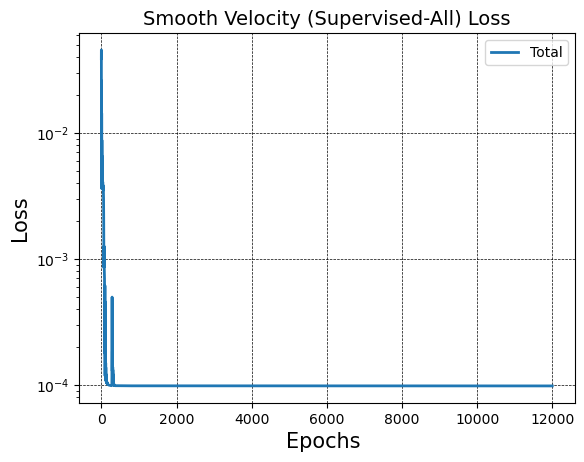

In [26]:
# Plotting the Loss Curve
plt.semilogy(loss_value, label="Total", linewidth=2) # Plots the total loss

plt.title("Smooth Velocity (Supervised-All) Loss", fontsize=14)   # Sets the title of the figure

plt.xlabel("Epochs ", fontsize=15)              # Sets the x-axis label of the figure
plt.ylabel("Loss", fontsize=15,)                # Sets the y-axis label of the figure

plt.grid(color = 'black', linestyle = '--', linewidth = 0.5) # Sets the grid of the figure

plt.legend(loc="upper right")   # Sets the legend of the figure

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Smooth Velocity (Supervised-All) Loss.pdf", format="pdf", bbox_inches="tight") # Saves the figure

plt.show() # Displays the figure

In [27]:
tau_pred = tau(params,X_star[0].reshape(-1,1),X_star[1].reshape(-1,1))
T_pred =tau_pred*T0.reshape(-1,1)

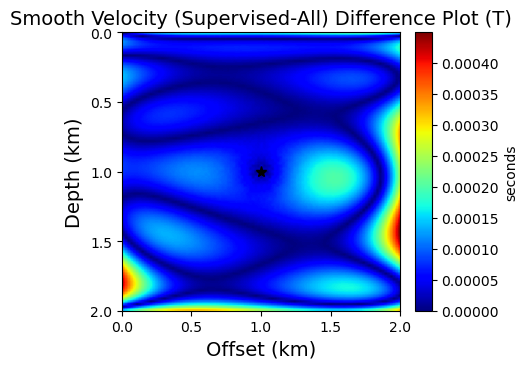

In [28]:
# Tau predicted and tau analytical difference plot

plt.style.use('default')         # Sets the default style for the plot

plt.figure(figsize=(4,4))        # Creates a new figure with a size of 4x4 inches

plt.title("Smooth Velocity (Supervised-All) Difference Plot (T)", fontsize=14)    # Sets the title of the figure

ax = plt.gca()                   # Gets the current axes instance
im = ax.imshow(jnp.abs(T_pred.reshape(101,101)-T_data), extent=[x_min,x_max,z_max,z_min], aspect=1, cmap="jet")   # Plots the velocity model velmodel as an image on the current axes (ax)

ax.plot(sx,sz,'k*',markersize=8) # Plots a black star marker at the source location 

plt.xlabel('Offset (km)', fontsize=14)     # Sets the label for the x-axis
plt.xticks(fontsize=10)          # Sets the font size for the x-axis tick labels

plt.ylabel('Depth (km)', fontsize=14)      # Sets the label for the y-axis
plt.yticks(fontsize=10)          # Sets the font size for the y-axis tick labels

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the major tick locator for the x-axis to have ticks at intervals of 0.5.
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the major tick locator for the y-axis to have ticks at intervals of 0.5.

divider = make_axes_locatable(ax)         # Creates a divider to make room for the colorbar
cax = divider.append_axes("right", size="6%", pad=0.15) # Appends an axes on the right side of the plot to accommodate the colorbar

cbar = plt.colorbar(im, cax=cax) # Adds a colorbar to the plot using the image im and the colorbar axes cax

cbar.set_label('seconds',size=10)   # Sets the label for the colorbar.
cbar.ax.tick_params(labelsize=10)        # Sets the font size of the colorbar tick labels.

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Smooth Velocity (Supervised) Difference Plot (Tau).pdf", format= "pdf",bbox_inches="tight")  # Saves the image as a pdf file at the specified file directory

plt.show()   # Displays the defined image

In [29]:
# Load fast sweeping traveltims for comparison
T_fsm = jnp.load("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/inputs/vofz/traveltimes/Tcomp.npy")

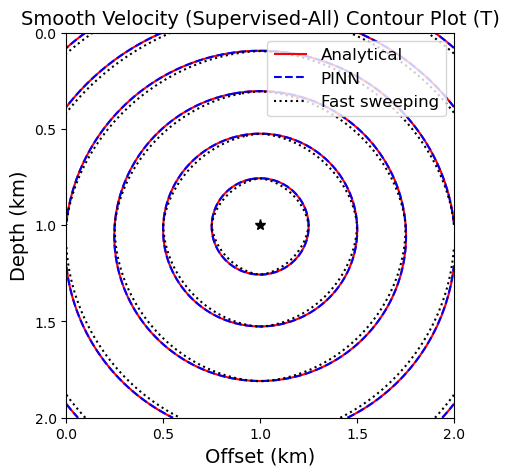

In [30]:
# Traveltime contour plots

plt.figure(figsize=(5,5)) # Creates a new figure with a size of 5x5 inches

ax = plt.gca()      # Gets the current axes instance

plt.title("Smooth Velocity (Supervised-All) Contour Plot (T)", fontsize=14)    # Sets the title of the figure

# Plots the contours of the difference T values as an image
im1 = ax.contour(T_data.reshape(101,101), 6, extent=[x_min,x_max,z_min,z_max], colors='r')
im2 = ax.contour(T_pred.reshape(101,101), 6, extent=[x_min,x_max,z_min,z_max], colors='b',linestyles = 'dashed')
im3 = ax.contour(T_fsm.reshape(101,101), 6, extent=[x_min,x_max,z_min,z_max], colors='k',linestyles = 'dotted')


ax.plot(sx,sz,'k*',markersize=8) # Plots a black star marker at the source location 

plt.xlabel('Offset (km)', fontsize=14)   # Sets the x-axis label
plt.ylabel('Depth (km)', fontsize=14)    # Sets the y-axis label

ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()

# Sets im1 legend
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()

ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'PINN', 'Fast sweeping'],fontsize=12)  # Sets the combined legend

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the x-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the y-axis

plt.xticks(fontsize=10)   # Sets the x-axis ticks
plt.yticks(fontsize=10)   # Sets the y-axis ticks

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Smooth Velocity (Supervised-All) Contour Plot (T).pdf", format="pdf", bbox_inches="tight")

plt.show()

In [31]:
# Determining the accuracy of the model by quantifying the difference between T_pred and T_data using Vector Norm
print(jnp.linalg.norm(T_pred-T_data.reshape(-1,1))/jnp.linalg.norm(T_data))
print(jnp.linalg.norm(T_pred-T_data.reshape(-1,1)))

0.00028345847
0.009519526


<a id="tau_pred"></a>
#### Model Training (Selected Points)

In [32]:
# reinitialises the parameters of the neural network based on the specified layer architecture.
params = init_params(layers)

In [33]:
%%time
epochs = 12000 
loss_value = [] # List to hold the values of the combines loss

for epoch in range(epochs):  # For loop to iterate over the stipulates epochs
    opt_state, params = update(opt_state,params,true_tau_f,X_starf) # Trains using selected data points

    # print loss and epoch info
    if epoch%(1) ==0:
        loss_pp = loss_fun(params,true_tau_f,X_starf) # Computes the total loss
        loss_value.append(loss_pp)                                    # Appends the total loss value to the declared list
        print(f'Epoch = {epoch},\tloss = {loss_pp:.3e}')              # Prints the total loss values for each epoch

Epoch = 0,	loss = 6.711e-02
Epoch = 1,	loss = 6.431e-02
Epoch = 2,	loss = 6.113e-02
Epoch = 3,	loss = 5.774e-02
Epoch = 4,	loss = 5.425e-02
Epoch = 5,	loss = 5.075e-02
Epoch = 6,	loss = 4.727e-02
Epoch = 7,	loss = 4.388e-02
Epoch = 8,	loss = 4.061e-02
Epoch = 9,	loss = 3.747e-02
Epoch = 10,	loss = 3.447e-02
Epoch = 11,	loss = 3.165e-02
Epoch = 12,	loss = 2.899e-02
Epoch = 13,	loss = 2.650e-02
Epoch = 14,	loss = 2.418e-02
Epoch = 15,	loss = 2.203e-02
Epoch = 16,	loss = 2.005e-02
Epoch = 17,	loss = 1.822e-02
Epoch = 18,	loss = 1.656e-02
Epoch = 19,	loss = 1.503e-02
Epoch = 20,	loss = 1.365e-02
Epoch = 21,	loss = 1.240e-02
Epoch = 22,	loss = 1.127e-02
Epoch = 23,	loss = 1.026e-02
Epoch = 24,	loss = 9.359e-03
Epoch = 25,	loss = 8.555e-03
Epoch = 26,	loss = 7.842e-03
Epoch = 27,	loss = 7.214e-03
Epoch = 28,	loss = 6.662e-03
Epoch = 29,	loss = 6.180e-03
Epoch = 30,	loss = 5.762e-03
Epoch = 31,	loss = 5.400e-03
Epoch = 32,	loss = 5.089e-03
Epoch = 33,	loss = 4.825e-03
Epoch = 34,	loss = 4.600

Epoch = 373,	loss = 3.688e-03
Epoch = 374,	loss = 3.688e-03
Epoch = 375,	loss = 3.688e-03
Epoch = 376,	loss = 3.688e-03
Epoch = 377,	loss = 3.688e-03
Epoch = 378,	loss = 3.688e-03
Epoch = 379,	loss = 3.688e-03
Epoch = 380,	loss = 3.688e-03
Epoch = 381,	loss = 3.688e-03
Epoch = 382,	loss = 3.688e-03
Epoch = 383,	loss = 3.688e-03
Epoch = 384,	loss = 3.688e-03
Epoch = 385,	loss = 3.688e-03
Epoch = 386,	loss = 3.688e-03
Epoch = 387,	loss = 3.688e-03
Epoch = 388,	loss = 3.688e-03
Epoch = 389,	loss = 3.688e-03
Epoch = 390,	loss = 3.688e-03
Epoch = 391,	loss = 3.688e-03
Epoch = 392,	loss = 3.688e-03
Epoch = 393,	loss = 3.688e-03
Epoch = 394,	loss = 3.688e-03
Epoch = 395,	loss = 3.688e-03
Epoch = 396,	loss = 3.688e-03
Epoch = 397,	loss = 3.688e-03
Epoch = 398,	loss = 3.688e-03
Epoch = 399,	loss = 3.688e-03
Epoch = 400,	loss = 3.688e-03
Epoch = 401,	loss = 3.688e-03
Epoch = 402,	loss = 3.688e-03
Epoch = 403,	loss = 3.688e-03
Epoch = 404,	loss = 3.688e-03
Epoch = 405,	loss = 3.688e-03
Epoch = 40

Epoch = 760,	loss = 3.688e-03
Epoch = 761,	loss = 3.688e-03
Epoch = 762,	loss = 3.688e-03
Epoch = 763,	loss = 3.688e-03
Epoch = 764,	loss = 3.688e-03
Epoch = 765,	loss = 3.688e-03
Epoch = 766,	loss = 3.688e-03
Epoch = 767,	loss = 3.688e-03
Epoch = 768,	loss = 3.688e-03
Epoch = 769,	loss = 3.688e-03
Epoch = 770,	loss = 3.688e-03
Epoch = 771,	loss = 3.688e-03
Epoch = 772,	loss = 3.688e-03
Epoch = 773,	loss = 3.688e-03
Epoch = 774,	loss = 3.688e-03
Epoch = 775,	loss = 3.688e-03
Epoch = 776,	loss = 3.688e-03
Epoch = 777,	loss = 3.688e-03
Epoch = 778,	loss = 3.688e-03
Epoch = 779,	loss = 3.688e-03
Epoch = 780,	loss = 3.688e-03
Epoch = 781,	loss = 3.688e-03
Epoch = 782,	loss = 3.688e-03
Epoch = 783,	loss = 3.688e-03
Epoch = 784,	loss = 3.688e-03
Epoch = 785,	loss = 3.688e-03
Epoch = 786,	loss = 3.688e-03
Epoch = 787,	loss = 3.688e-03
Epoch = 788,	loss = 3.688e-03
Epoch = 789,	loss = 3.688e-03
Epoch = 790,	loss = 3.688e-03
Epoch = 791,	loss = 3.688e-03
Epoch = 792,	loss = 3.688e-03
Epoch = 79

Epoch = 1146,	loss = 3.688e-03
Epoch = 1147,	loss = 3.688e-03
Epoch = 1148,	loss = 3.688e-03
Epoch = 1149,	loss = 3.688e-03
Epoch = 1150,	loss = 3.688e-03
Epoch = 1151,	loss = 3.688e-03
Epoch = 1152,	loss = 3.688e-03
Epoch = 1153,	loss = 3.688e-03
Epoch = 1154,	loss = 3.688e-03
Epoch = 1155,	loss = 3.688e-03
Epoch = 1156,	loss = 3.688e-03
Epoch = 1157,	loss = 3.688e-03
Epoch = 1158,	loss = 3.688e-03
Epoch = 1159,	loss = 3.688e-03
Epoch = 1160,	loss = 3.688e-03
Epoch = 1161,	loss = 3.688e-03
Epoch = 1162,	loss = 3.688e-03
Epoch = 1163,	loss = 3.688e-03
Epoch = 1164,	loss = 3.688e-03
Epoch = 1165,	loss = 3.688e-03
Epoch = 1166,	loss = 3.688e-03
Epoch = 1167,	loss = 3.688e-03
Epoch = 1168,	loss = 3.688e-03
Epoch = 1169,	loss = 3.688e-03
Epoch = 1170,	loss = 3.688e-03
Epoch = 1171,	loss = 3.688e-03
Epoch = 1172,	loss = 3.688e-03
Epoch = 1173,	loss = 3.688e-03
Epoch = 1174,	loss = 3.688e-03
Epoch = 1175,	loss = 3.688e-03
Epoch = 1176,	loss = 3.688e-03
Epoch = 1177,	loss = 3.688e-03
Epoch = 

Epoch = 1531,	loss = 3.688e-03
Epoch = 1532,	loss = 3.688e-03
Epoch = 1533,	loss = 3.688e-03
Epoch = 1534,	loss = 3.688e-03
Epoch = 1535,	loss = 3.688e-03
Epoch = 1536,	loss = 3.688e-03
Epoch = 1537,	loss = 3.688e-03
Epoch = 1538,	loss = 3.688e-03
Epoch = 1539,	loss = 3.688e-03
Epoch = 1540,	loss = 3.688e-03
Epoch = 1541,	loss = 3.688e-03
Epoch = 1542,	loss = 3.688e-03
Epoch = 1543,	loss = 3.688e-03
Epoch = 1544,	loss = 3.688e-03
Epoch = 1545,	loss = 3.688e-03
Epoch = 1546,	loss = 3.688e-03
Epoch = 1547,	loss = 3.688e-03
Epoch = 1548,	loss = 3.688e-03
Epoch = 1549,	loss = 3.688e-03
Epoch = 1550,	loss = 3.688e-03
Epoch = 1551,	loss = 3.688e-03
Epoch = 1552,	loss = 3.688e-03
Epoch = 1553,	loss = 3.688e-03
Epoch = 1554,	loss = 3.688e-03
Epoch = 1555,	loss = 3.688e-03
Epoch = 1556,	loss = 3.688e-03
Epoch = 1557,	loss = 3.688e-03
Epoch = 1558,	loss = 3.688e-03
Epoch = 1559,	loss = 3.688e-03
Epoch = 1560,	loss = 3.688e-03
Epoch = 1561,	loss = 3.688e-03
Epoch = 1562,	loss = 3.688e-03
Epoch = 

Epoch = 1917,	loss = 3.688e-03
Epoch = 1918,	loss = 3.688e-03
Epoch = 1919,	loss = 3.688e-03
Epoch = 1920,	loss = 3.688e-03
Epoch = 1921,	loss = 3.688e-03
Epoch = 1922,	loss = 3.688e-03
Epoch = 1923,	loss = 3.688e-03
Epoch = 1924,	loss = 3.688e-03
Epoch = 1925,	loss = 3.688e-03
Epoch = 1926,	loss = 3.688e-03
Epoch = 1927,	loss = 3.688e-03
Epoch = 1928,	loss = 3.688e-03
Epoch = 1929,	loss = 3.688e-03
Epoch = 1930,	loss = 3.688e-03
Epoch = 1931,	loss = 3.688e-03
Epoch = 1932,	loss = 3.688e-03
Epoch = 1933,	loss = 3.688e-03
Epoch = 1934,	loss = 3.688e-03
Epoch = 1935,	loss = 3.688e-03
Epoch = 1936,	loss = 3.688e-03
Epoch = 1937,	loss = 3.688e-03
Epoch = 1938,	loss = 3.688e-03
Epoch = 1939,	loss = 3.688e-03
Epoch = 1940,	loss = 3.688e-03
Epoch = 1941,	loss = 3.688e-03
Epoch = 1942,	loss = 3.688e-03
Epoch = 1943,	loss = 3.688e-03
Epoch = 1944,	loss = 3.688e-03
Epoch = 1945,	loss = 3.688e-03
Epoch = 1946,	loss = 3.688e-03
Epoch = 1947,	loss = 3.688e-03
Epoch = 1948,	loss = 3.688e-03
Epoch = 

Epoch = 2303,	loss = 3.688e-03
Epoch = 2304,	loss = 3.688e-03
Epoch = 2305,	loss = 3.688e-03
Epoch = 2306,	loss = 3.688e-03
Epoch = 2307,	loss = 3.688e-03
Epoch = 2308,	loss = 3.688e-03
Epoch = 2309,	loss = 3.688e-03
Epoch = 2310,	loss = 3.688e-03
Epoch = 2311,	loss = 3.688e-03
Epoch = 2312,	loss = 3.688e-03
Epoch = 2313,	loss = 3.688e-03
Epoch = 2314,	loss = 3.688e-03
Epoch = 2315,	loss = 3.688e-03
Epoch = 2316,	loss = 3.688e-03
Epoch = 2317,	loss = 3.688e-03
Epoch = 2318,	loss = 3.688e-03
Epoch = 2319,	loss = 3.688e-03
Epoch = 2320,	loss = 3.688e-03
Epoch = 2321,	loss = 3.688e-03
Epoch = 2322,	loss = 3.688e-03
Epoch = 2323,	loss = 3.688e-03
Epoch = 2324,	loss = 3.688e-03
Epoch = 2325,	loss = 3.688e-03
Epoch = 2326,	loss = 3.688e-03
Epoch = 2327,	loss = 3.688e-03
Epoch = 2328,	loss = 3.688e-03
Epoch = 2329,	loss = 3.688e-03
Epoch = 2330,	loss = 3.688e-03
Epoch = 2331,	loss = 3.688e-03
Epoch = 2332,	loss = 3.688e-03
Epoch = 2333,	loss = 3.688e-03
Epoch = 2334,	loss = 3.688e-03
Epoch = 

Epoch = 2650,	loss = 3.688e-03
Epoch = 2651,	loss = 3.688e-03
Epoch = 2652,	loss = 3.688e-03
Epoch = 2653,	loss = 3.688e-03
Epoch = 2654,	loss = 3.688e-03
Epoch = 2655,	loss = 3.688e-03
Epoch = 2656,	loss = 3.688e-03
Epoch = 2657,	loss = 3.688e-03
Epoch = 2658,	loss = 3.688e-03
Epoch = 2659,	loss = 3.688e-03
Epoch = 2660,	loss = 3.688e-03
Epoch = 2661,	loss = 3.688e-03
Epoch = 2662,	loss = 3.688e-03
Epoch = 2663,	loss = 3.688e-03
Epoch = 2664,	loss = 3.688e-03
Epoch = 2665,	loss = 3.688e-03
Epoch = 2666,	loss = 3.688e-03
Epoch = 2667,	loss = 3.688e-03
Epoch = 2668,	loss = 3.688e-03
Epoch = 2669,	loss = 3.688e-03
Epoch = 2670,	loss = 3.688e-03
Epoch = 2671,	loss = 3.688e-03
Epoch = 2672,	loss = 3.688e-03
Epoch = 2673,	loss = 3.688e-03
Epoch = 2674,	loss = 3.688e-03
Epoch = 2675,	loss = 3.688e-03
Epoch = 2676,	loss = 3.688e-03
Epoch = 2677,	loss = 3.688e-03
Epoch = 2678,	loss = 3.688e-03
Epoch = 2679,	loss = 3.688e-03
Epoch = 2680,	loss = 3.688e-03
Epoch = 2681,	loss = 3.688e-03
Epoch = 

Epoch = 3001,	loss = 3.688e-03
Epoch = 3002,	loss = 3.688e-03
Epoch = 3003,	loss = 3.688e-03
Epoch = 3004,	loss = 3.688e-03
Epoch = 3005,	loss = 3.688e-03
Epoch = 3006,	loss = 3.688e-03
Epoch = 3007,	loss = 3.688e-03
Epoch = 3008,	loss = 3.688e-03
Epoch = 3009,	loss = 3.688e-03
Epoch = 3010,	loss = 3.688e-03
Epoch = 3011,	loss = 3.688e-03
Epoch = 3012,	loss = 3.688e-03
Epoch = 3013,	loss = 3.688e-03
Epoch = 3014,	loss = 3.688e-03
Epoch = 3015,	loss = 3.688e-03
Epoch = 3016,	loss = 3.688e-03
Epoch = 3017,	loss = 3.688e-03
Epoch = 3018,	loss = 3.688e-03
Epoch = 3019,	loss = 3.688e-03
Epoch = 3020,	loss = 3.688e-03
Epoch = 3021,	loss = 3.688e-03
Epoch = 3022,	loss = 3.688e-03
Epoch = 3023,	loss = 3.688e-03
Epoch = 3024,	loss = 3.688e-03
Epoch = 3025,	loss = 3.688e-03
Epoch = 3026,	loss = 3.688e-03
Epoch = 3027,	loss = 3.688e-03
Epoch = 3028,	loss = 3.688e-03
Epoch = 3029,	loss = 3.688e-03
Epoch = 3030,	loss = 3.688e-03
Epoch = 3031,	loss = 3.688e-03
Epoch = 3032,	loss = 3.688e-03
Epoch = 

Epoch = 3387,	loss = 3.688e-03
Epoch = 3388,	loss = 3.688e-03
Epoch = 3389,	loss = 3.688e-03
Epoch = 3390,	loss = 3.688e-03
Epoch = 3391,	loss = 3.688e-03
Epoch = 3392,	loss = 3.688e-03
Epoch = 3393,	loss = 3.688e-03
Epoch = 3394,	loss = 3.688e-03
Epoch = 3395,	loss = 3.688e-03
Epoch = 3396,	loss = 3.688e-03
Epoch = 3397,	loss = 3.688e-03
Epoch = 3398,	loss = 3.688e-03
Epoch = 3399,	loss = 3.688e-03
Epoch = 3400,	loss = 3.688e-03
Epoch = 3401,	loss = 3.688e-03
Epoch = 3402,	loss = 3.688e-03
Epoch = 3403,	loss = 3.688e-03
Epoch = 3404,	loss = 3.688e-03
Epoch = 3405,	loss = 3.688e-03
Epoch = 3406,	loss = 3.688e-03
Epoch = 3407,	loss = 3.688e-03
Epoch = 3408,	loss = 3.688e-03
Epoch = 3409,	loss = 3.688e-03
Epoch = 3410,	loss = 3.688e-03
Epoch = 3411,	loss = 3.688e-03
Epoch = 3412,	loss = 3.688e-03
Epoch = 3413,	loss = 3.688e-03
Epoch = 3414,	loss = 3.688e-03
Epoch = 3415,	loss = 3.688e-03
Epoch = 3416,	loss = 3.688e-03
Epoch = 3417,	loss = 3.688e-03
Epoch = 3418,	loss = 3.688e-03
Epoch = 

Epoch = 3774,	loss = 3.688e-03
Epoch = 3775,	loss = 3.688e-03
Epoch = 3776,	loss = 3.688e-03
Epoch = 3777,	loss = 3.688e-03
Epoch = 3778,	loss = 3.688e-03
Epoch = 3779,	loss = 3.688e-03
Epoch = 3780,	loss = 3.688e-03
Epoch = 3781,	loss = 3.688e-03
Epoch = 3782,	loss = 3.688e-03
Epoch = 3783,	loss = 3.688e-03
Epoch = 3784,	loss = 3.688e-03
Epoch = 3785,	loss = 3.688e-03
Epoch = 3786,	loss = 3.688e-03
Epoch = 3787,	loss = 3.688e-03
Epoch = 3788,	loss = 3.688e-03
Epoch = 3789,	loss = 3.688e-03
Epoch = 3790,	loss = 3.688e-03
Epoch = 3791,	loss = 3.688e-03
Epoch = 3792,	loss = 3.688e-03
Epoch = 3793,	loss = 3.688e-03
Epoch = 3794,	loss = 3.688e-03
Epoch = 3795,	loss = 3.688e-03
Epoch = 3796,	loss = 3.688e-03
Epoch = 3797,	loss = 3.688e-03
Epoch = 3798,	loss = 3.688e-03
Epoch = 3799,	loss = 3.688e-03
Epoch = 3800,	loss = 3.688e-03
Epoch = 3801,	loss = 3.688e-03
Epoch = 3802,	loss = 3.688e-03
Epoch = 3803,	loss = 3.688e-03
Epoch = 3804,	loss = 3.688e-03
Epoch = 3805,	loss = 3.688e-03
Epoch = 

Epoch = 4151,	loss = 3.688e-03
Epoch = 4152,	loss = 3.688e-03
Epoch = 4153,	loss = 3.688e-03
Epoch = 4154,	loss = 3.688e-03
Epoch = 4155,	loss = 3.688e-03
Epoch = 4156,	loss = 3.688e-03
Epoch = 4157,	loss = 3.688e-03
Epoch = 4158,	loss = 3.688e-03
Epoch = 4159,	loss = 3.688e-03
Epoch = 4160,	loss = 3.688e-03
Epoch = 4161,	loss = 3.688e-03
Epoch = 4162,	loss = 3.688e-03
Epoch = 4163,	loss = 3.688e-03
Epoch = 4164,	loss = 3.688e-03
Epoch = 4165,	loss = 3.688e-03
Epoch = 4166,	loss = 3.688e-03
Epoch = 4167,	loss = 3.688e-03
Epoch = 4168,	loss = 3.688e-03
Epoch = 4169,	loss = 3.688e-03
Epoch = 4170,	loss = 3.688e-03
Epoch = 4171,	loss = 3.688e-03
Epoch = 4172,	loss = 3.688e-03
Epoch = 4173,	loss = 3.688e-03
Epoch = 4174,	loss = 3.688e-03
Epoch = 4175,	loss = 3.688e-03
Epoch = 4176,	loss = 3.688e-03
Epoch = 4177,	loss = 3.688e-03
Epoch = 4178,	loss = 3.688e-03
Epoch = 4179,	loss = 3.688e-03
Epoch = 4180,	loss = 3.688e-03
Epoch = 4181,	loss = 3.688e-03
Epoch = 4182,	loss = 3.688e-03
Epoch = 

Epoch = 4537,	loss = 3.688e-03
Epoch = 4538,	loss = 3.688e-03
Epoch = 4539,	loss = 3.688e-03
Epoch = 4540,	loss = 3.688e-03
Epoch = 4541,	loss = 3.688e-03
Epoch = 4542,	loss = 3.688e-03
Epoch = 4543,	loss = 3.688e-03
Epoch = 4544,	loss = 3.688e-03
Epoch = 4545,	loss = 3.688e-03
Epoch = 4546,	loss = 3.688e-03
Epoch = 4547,	loss = 3.688e-03
Epoch = 4548,	loss = 3.688e-03
Epoch = 4549,	loss = 3.688e-03
Epoch = 4550,	loss = 3.688e-03
Epoch = 4551,	loss = 3.688e-03
Epoch = 4552,	loss = 3.688e-03
Epoch = 4553,	loss = 3.688e-03
Epoch = 4554,	loss = 3.688e-03
Epoch = 4555,	loss = 3.688e-03
Epoch = 4556,	loss = 3.688e-03
Epoch = 4557,	loss = 3.688e-03
Epoch = 4558,	loss = 3.688e-03
Epoch = 4559,	loss = 3.688e-03
Epoch = 4560,	loss = 3.688e-03
Epoch = 4561,	loss = 3.688e-03
Epoch = 4562,	loss = 3.688e-03
Epoch = 4563,	loss = 3.688e-03
Epoch = 4564,	loss = 3.688e-03
Epoch = 4565,	loss = 3.688e-03
Epoch = 4566,	loss = 3.688e-03
Epoch = 4567,	loss = 3.688e-03
Epoch = 4568,	loss = 3.688e-03
Epoch = 

Epoch = 4922,	loss = 3.688e-03
Epoch = 4923,	loss = 3.688e-03
Epoch = 4924,	loss = 3.688e-03
Epoch = 4925,	loss = 3.688e-03
Epoch = 4926,	loss = 3.688e-03
Epoch = 4927,	loss = 3.688e-03
Epoch = 4928,	loss = 3.688e-03
Epoch = 4929,	loss = 3.688e-03
Epoch = 4930,	loss = 3.688e-03
Epoch = 4931,	loss = 3.688e-03
Epoch = 4932,	loss = 3.688e-03
Epoch = 4933,	loss = 3.688e-03
Epoch = 4934,	loss = 3.688e-03
Epoch = 4935,	loss = 3.688e-03
Epoch = 4936,	loss = 3.688e-03
Epoch = 4937,	loss = 3.688e-03
Epoch = 4938,	loss = 3.688e-03
Epoch = 4939,	loss = 3.688e-03
Epoch = 4940,	loss = 3.688e-03
Epoch = 4941,	loss = 3.688e-03
Epoch = 4942,	loss = 3.688e-03
Epoch = 4943,	loss = 3.688e-03
Epoch = 4944,	loss = 3.688e-03
Epoch = 4945,	loss = 3.688e-03
Epoch = 4946,	loss = 3.688e-03
Epoch = 4947,	loss = 3.688e-03
Epoch = 4948,	loss = 3.688e-03
Epoch = 4949,	loss = 3.688e-03
Epoch = 4950,	loss = 3.688e-03
Epoch = 4951,	loss = 3.688e-03
Epoch = 4952,	loss = 3.688e-03
Epoch = 4953,	loss = 3.688e-03
Epoch = 

Epoch = 5307,	loss = 3.688e-03
Epoch = 5308,	loss = 3.688e-03
Epoch = 5309,	loss = 3.688e-03
Epoch = 5310,	loss = 3.688e-03
Epoch = 5311,	loss = 3.688e-03
Epoch = 5312,	loss = 3.688e-03
Epoch = 5313,	loss = 3.688e-03
Epoch = 5314,	loss = 3.688e-03
Epoch = 5315,	loss = 3.688e-03
Epoch = 5316,	loss = 3.688e-03
Epoch = 5317,	loss = 3.688e-03
Epoch = 5318,	loss = 3.688e-03
Epoch = 5319,	loss = 3.688e-03
Epoch = 5320,	loss = 3.688e-03
Epoch = 5321,	loss = 3.688e-03
Epoch = 5322,	loss = 3.688e-03
Epoch = 5323,	loss = 3.688e-03
Epoch = 5324,	loss = 3.688e-03
Epoch = 5325,	loss = 3.688e-03
Epoch = 5326,	loss = 3.688e-03
Epoch = 5327,	loss = 3.688e-03
Epoch = 5328,	loss = 3.688e-03
Epoch = 5329,	loss = 3.688e-03
Epoch = 5330,	loss = 3.688e-03
Epoch = 5331,	loss = 3.688e-03
Epoch = 5332,	loss = 3.688e-03
Epoch = 5333,	loss = 3.688e-03
Epoch = 5334,	loss = 3.688e-03
Epoch = 5335,	loss = 3.688e-03
Epoch = 5336,	loss = 3.688e-03
Epoch = 5337,	loss = 3.688e-03
Epoch = 5338,	loss = 3.688e-03
Epoch = 

Epoch = 5693,	loss = 3.688e-03
Epoch = 5694,	loss = 3.688e-03
Epoch = 5695,	loss = 3.688e-03
Epoch = 5696,	loss = 3.688e-03
Epoch = 5697,	loss = 3.688e-03
Epoch = 5698,	loss = 3.688e-03
Epoch = 5699,	loss = 3.688e-03
Epoch = 5700,	loss = 3.688e-03
Epoch = 5701,	loss = 3.688e-03
Epoch = 5702,	loss = 3.688e-03
Epoch = 5703,	loss = 3.688e-03
Epoch = 5704,	loss = 3.688e-03
Epoch = 5705,	loss = 3.688e-03
Epoch = 5706,	loss = 3.688e-03
Epoch = 5707,	loss = 3.688e-03
Epoch = 5708,	loss = 3.688e-03
Epoch = 5709,	loss = 3.688e-03
Epoch = 5710,	loss = 3.688e-03
Epoch = 5711,	loss = 3.688e-03
Epoch = 5712,	loss = 3.688e-03
Epoch = 5713,	loss = 3.688e-03
Epoch = 5714,	loss = 3.688e-03
Epoch = 5715,	loss = 3.688e-03
Epoch = 5716,	loss = 3.688e-03
Epoch = 5717,	loss = 3.688e-03
Epoch = 5718,	loss = 3.688e-03
Epoch = 5719,	loss = 3.688e-03
Epoch = 5720,	loss = 3.688e-03
Epoch = 5721,	loss = 3.688e-03
Epoch = 5722,	loss = 3.688e-03
Epoch = 5723,	loss = 3.688e-03
Epoch = 5724,	loss = 3.688e-03
Epoch = 

Epoch = 6079,	loss = 3.688e-03
Epoch = 6080,	loss = 3.688e-03
Epoch = 6081,	loss = 3.688e-03
Epoch = 6082,	loss = 3.688e-03
Epoch = 6083,	loss = 3.688e-03
Epoch = 6084,	loss = 3.688e-03
Epoch = 6085,	loss = 3.688e-03
Epoch = 6086,	loss = 3.688e-03
Epoch = 6087,	loss = 3.688e-03
Epoch = 6088,	loss = 3.688e-03
Epoch = 6089,	loss = 3.688e-03
Epoch = 6090,	loss = 3.688e-03
Epoch = 6091,	loss = 3.688e-03
Epoch = 6092,	loss = 3.688e-03
Epoch = 6093,	loss = 3.688e-03
Epoch = 6094,	loss = 3.688e-03
Epoch = 6095,	loss = 3.688e-03
Epoch = 6096,	loss = 3.688e-03
Epoch = 6097,	loss = 3.688e-03
Epoch = 6098,	loss = 3.688e-03
Epoch = 6099,	loss = 3.688e-03
Epoch = 6100,	loss = 3.688e-03
Epoch = 6101,	loss = 3.688e-03
Epoch = 6102,	loss = 3.688e-03
Epoch = 6103,	loss = 3.688e-03
Epoch = 6104,	loss = 3.688e-03
Epoch = 6105,	loss = 3.688e-03
Epoch = 6106,	loss = 3.688e-03
Epoch = 6107,	loss = 3.688e-03
Epoch = 6108,	loss = 3.688e-03
Epoch = 6109,	loss = 3.688e-03
Epoch = 6110,	loss = 3.688e-03
Epoch = 

Epoch = 6463,	loss = 3.688e-03
Epoch = 6464,	loss = 3.688e-03
Epoch = 6465,	loss = 3.688e-03
Epoch = 6466,	loss = 3.688e-03
Epoch = 6467,	loss = 3.688e-03
Epoch = 6468,	loss = 3.688e-03
Epoch = 6469,	loss = 3.688e-03
Epoch = 6470,	loss = 3.688e-03
Epoch = 6471,	loss = 3.688e-03
Epoch = 6472,	loss = 3.688e-03
Epoch = 6473,	loss = 3.688e-03
Epoch = 6474,	loss = 3.688e-03
Epoch = 6475,	loss = 3.688e-03
Epoch = 6476,	loss = 3.688e-03
Epoch = 6477,	loss = 3.688e-03
Epoch = 6478,	loss = 3.688e-03
Epoch = 6479,	loss = 3.688e-03
Epoch = 6480,	loss = 3.688e-03
Epoch = 6481,	loss = 3.688e-03
Epoch = 6482,	loss = 3.688e-03
Epoch = 6483,	loss = 3.688e-03
Epoch = 6484,	loss = 3.688e-03
Epoch = 6485,	loss = 3.688e-03
Epoch = 6486,	loss = 3.688e-03
Epoch = 6487,	loss = 3.688e-03
Epoch = 6488,	loss = 3.688e-03
Epoch = 6489,	loss = 3.688e-03
Epoch = 6490,	loss = 3.688e-03
Epoch = 6491,	loss = 3.688e-03
Epoch = 6492,	loss = 3.688e-03
Epoch = 6493,	loss = 3.688e-03
Epoch = 6494,	loss = 3.688e-03
Epoch = 

Epoch = 6846,	loss = 3.688e-03
Epoch = 6847,	loss = 3.688e-03
Epoch = 6848,	loss = 3.688e-03
Epoch = 6849,	loss = 3.688e-03
Epoch = 6850,	loss = 3.688e-03
Epoch = 6851,	loss = 3.688e-03
Epoch = 6852,	loss = 3.688e-03
Epoch = 6853,	loss = 3.688e-03
Epoch = 6854,	loss = 3.688e-03
Epoch = 6855,	loss = 3.688e-03
Epoch = 6856,	loss = 3.688e-03
Epoch = 6857,	loss = 3.688e-03
Epoch = 6858,	loss = 3.688e-03
Epoch = 6859,	loss = 3.688e-03
Epoch = 6860,	loss = 3.688e-03
Epoch = 6861,	loss = 3.688e-03
Epoch = 6862,	loss = 3.688e-03
Epoch = 6863,	loss = 3.688e-03
Epoch = 6864,	loss = 3.688e-03
Epoch = 6865,	loss = 3.688e-03
Epoch = 6866,	loss = 3.688e-03
Epoch = 6867,	loss = 3.688e-03
Epoch = 6868,	loss = 3.688e-03
Epoch = 6869,	loss = 3.688e-03
Epoch = 6870,	loss = 3.688e-03
Epoch = 6871,	loss = 3.688e-03
Epoch = 6872,	loss = 3.688e-03
Epoch = 6873,	loss = 3.688e-03
Epoch = 6874,	loss = 3.688e-03
Epoch = 6875,	loss = 3.688e-03
Epoch = 6876,	loss = 3.688e-03
Epoch = 6877,	loss = 3.688e-03
Epoch = 

Epoch = 7230,	loss = 3.688e-03
Epoch = 7231,	loss = 3.688e-03
Epoch = 7232,	loss = 3.688e-03
Epoch = 7233,	loss = 3.688e-03
Epoch = 7234,	loss = 3.688e-03
Epoch = 7235,	loss = 3.688e-03
Epoch = 7236,	loss = 3.688e-03
Epoch = 7237,	loss = 3.688e-03
Epoch = 7238,	loss = 3.688e-03
Epoch = 7239,	loss = 3.688e-03
Epoch = 7240,	loss = 3.688e-03
Epoch = 7241,	loss = 3.688e-03
Epoch = 7242,	loss = 3.688e-03
Epoch = 7243,	loss = 3.688e-03
Epoch = 7244,	loss = 3.688e-03
Epoch = 7245,	loss = 3.688e-03
Epoch = 7246,	loss = 3.688e-03
Epoch = 7247,	loss = 3.688e-03
Epoch = 7248,	loss = 3.688e-03
Epoch = 7249,	loss = 3.688e-03
Epoch = 7250,	loss = 3.688e-03
Epoch = 7251,	loss = 3.688e-03
Epoch = 7252,	loss = 3.688e-03
Epoch = 7253,	loss = 3.688e-03
Epoch = 7254,	loss = 3.688e-03
Epoch = 7255,	loss = 3.688e-03
Epoch = 7256,	loss = 3.688e-03
Epoch = 7257,	loss = 3.688e-03
Epoch = 7258,	loss = 3.688e-03
Epoch = 7259,	loss = 3.688e-03
Epoch = 7260,	loss = 3.688e-03
Epoch = 7261,	loss = 3.688e-03
Epoch = 

Epoch = 7588,	loss = 3.688e-03
Epoch = 7589,	loss = 3.688e-03
Epoch = 7590,	loss = 3.688e-03
Epoch = 7591,	loss = 3.688e-03
Epoch = 7592,	loss = 3.688e-03
Epoch = 7593,	loss = 3.688e-03
Epoch = 7594,	loss = 3.688e-03
Epoch = 7595,	loss = 3.688e-03
Epoch = 7596,	loss = 3.688e-03
Epoch = 7597,	loss = 3.688e-03
Epoch = 7598,	loss = 3.688e-03
Epoch = 7599,	loss = 3.688e-03
Epoch = 7600,	loss = 3.688e-03
Epoch = 7601,	loss = 3.688e-03
Epoch = 7602,	loss = 3.688e-03
Epoch = 7603,	loss = 3.688e-03
Epoch = 7604,	loss = 3.688e-03
Epoch = 7605,	loss = 3.688e-03
Epoch = 7606,	loss = 3.688e-03
Epoch = 7607,	loss = 3.688e-03
Epoch = 7608,	loss = 3.688e-03
Epoch = 7609,	loss = 3.688e-03
Epoch = 7610,	loss = 3.688e-03
Epoch = 7611,	loss = 3.688e-03
Epoch = 7612,	loss = 3.688e-03
Epoch = 7613,	loss = 3.688e-03
Epoch = 7614,	loss = 3.688e-03
Epoch = 7615,	loss = 3.688e-03
Epoch = 7616,	loss = 3.688e-03
Epoch = 7617,	loss = 3.688e-03
Epoch = 7618,	loss = 3.688e-03
Epoch = 7619,	loss = 3.688e-03
Epoch = 

Epoch = 7968,	loss = 3.688e-03
Epoch = 7969,	loss = 3.688e-03
Epoch = 7970,	loss = 3.688e-03
Epoch = 7971,	loss = 3.688e-03
Epoch = 7972,	loss = 3.688e-03
Epoch = 7973,	loss = 3.688e-03
Epoch = 7974,	loss = 3.688e-03
Epoch = 7975,	loss = 3.688e-03
Epoch = 7976,	loss = 3.688e-03
Epoch = 7977,	loss = 3.688e-03
Epoch = 7978,	loss = 3.688e-03
Epoch = 7979,	loss = 3.688e-03
Epoch = 7980,	loss = 3.688e-03
Epoch = 7981,	loss = 3.688e-03
Epoch = 7982,	loss = 3.688e-03
Epoch = 7983,	loss = 3.688e-03
Epoch = 7984,	loss = 3.688e-03
Epoch = 7985,	loss = 3.688e-03
Epoch = 7986,	loss = 3.688e-03
Epoch = 7987,	loss = 3.688e-03
Epoch = 7988,	loss = 3.688e-03
Epoch = 7989,	loss = 3.688e-03
Epoch = 7990,	loss = 3.688e-03
Epoch = 7991,	loss = 3.688e-03
Epoch = 7992,	loss = 3.688e-03
Epoch = 7993,	loss = 3.688e-03
Epoch = 7994,	loss = 3.688e-03
Epoch = 7995,	loss = 3.688e-03
Epoch = 7996,	loss = 3.688e-03
Epoch = 7997,	loss = 3.688e-03
Epoch = 7998,	loss = 3.688e-03
Epoch = 7999,	loss = 3.688e-03
Epoch = 

Epoch = 8350,	loss = 3.688e-03
Epoch = 8351,	loss = 3.688e-03
Epoch = 8352,	loss = 3.688e-03
Epoch = 8353,	loss = 3.688e-03
Epoch = 8354,	loss = 3.688e-03
Epoch = 8355,	loss = 3.688e-03
Epoch = 8356,	loss = 3.688e-03
Epoch = 8357,	loss = 3.688e-03
Epoch = 8358,	loss = 3.688e-03
Epoch = 8359,	loss = 3.688e-03
Epoch = 8360,	loss = 3.688e-03
Epoch = 8361,	loss = 3.688e-03
Epoch = 8362,	loss = 3.688e-03
Epoch = 8363,	loss = 3.688e-03
Epoch = 8364,	loss = 3.688e-03
Epoch = 8365,	loss = 3.688e-03
Epoch = 8366,	loss = 3.688e-03
Epoch = 8367,	loss = 3.688e-03
Epoch = 8368,	loss = 3.688e-03
Epoch = 8369,	loss = 3.688e-03
Epoch = 8370,	loss = 3.688e-03
Epoch = 8371,	loss = 3.688e-03
Epoch = 8372,	loss = 3.688e-03
Epoch = 8373,	loss = 3.688e-03
Epoch = 8374,	loss = 3.688e-03
Epoch = 8375,	loss = 3.688e-03
Epoch = 8376,	loss = 3.688e-03
Epoch = 8377,	loss = 3.688e-03
Epoch = 8378,	loss = 3.688e-03
Epoch = 8379,	loss = 3.688e-03
Epoch = 8380,	loss = 3.688e-03
Epoch = 8381,	loss = 3.688e-03
Epoch = 

Epoch = 8733,	loss = 3.688e-03
Epoch = 8734,	loss = 3.688e-03
Epoch = 8735,	loss = 3.688e-03
Epoch = 8736,	loss = 3.688e-03
Epoch = 8737,	loss = 3.688e-03
Epoch = 8738,	loss = 3.688e-03
Epoch = 8739,	loss = 3.688e-03
Epoch = 8740,	loss = 3.688e-03
Epoch = 8741,	loss = 3.688e-03
Epoch = 8742,	loss = 3.688e-03
Epoch = 8743,	loss = 3.688e-03
Epoch = 8744,	loss = 3.688e-03
Epoch = 8745,	loss = 3.688e-03
Epoch = 8746,	loss = 3.688e-03
Epoch = 8747,	loss = 3.688e-03
Epoch = 8748,	loss = 3.688e-03
Epoch = 8749,	loss = 3.688e-03
Epoch = 8750,	loss = 3.688e-03
Epoch = 8751,	loss = 3.688e-03
Epoch = 8752,	loss = 3.688e-03
Epoch = 8753,	loss = 3.688e-03
Epoch = 8754,	loss = 3.688e-03
Epoch = 8755,	loss = 3.688e-03
Epoch = 8756,	loss = 3.688e-03
Epoch = 8757,	loss = 3.688e-03
Epoch = 8758,	loss = 3.688e-03
Epoch = 8759,	loss = 3.688e-03
Epoch = 8760,	loss = 3.688e-03
Epoch = 8761,	loss = 3.688e-03
Epoch = 8762,	loss = 3.688e-03
Epoch = 8763,	loss = 3.688e-03
Epoch = 8764,	loss = 3.688e-03
Epoch = 

Epoch = 9111,	loss = 3.688e-03
Epoch = 9112,	loss = 3.688e-03
Epoch = 9113,	loss = 3.688e-03
Epoch = 9114,	loss = 3.688e-03
Epoch = 9115,	loss = 3.688e-03
Epoch = 9116,	loss = 3.688e-03
Epoch = 9117,	loss = 3.688e-03
Epoch = 9118,	loss = 3.688e-03
Epoch = 9119,	loss = 3.688e-03
Epoch = 9120,	loss = 3.688e-03
Epoch = 9121,	loss = 3.688e-03
Epoch = 9122,	loss = 3.688e-03
Epoch = 9123,	loss = 3.688e-03
Epoch = 9124,	loss = 3.688e-03
Epoch = 9125,	loss = 3.688e-03
Epoch = 9126,	loss = 3.688e-03
Epoch = 9127,	loss = 3.688e-03
Epoch = 9128,	loss = 3.688e-03
Epoch = 9129,	loss = 3.688e-03
Epoch = 9130,	loss = 3.688e-03
Epoch = 9131,	loss = 3.688e-03
Epoch = 9132,	loss = 3.688e-03
Epoch = 9133,	loss = 3.688e-03
Epoch = 9134,	loss = 3.688e-03
Epoch = 9135,	loss = 3.688e-03
Epoch = 9136,	loss = 3.688e-03
Epoch = 9137,	loss = 3.688e-03
Epoch = 9138,	loss = 3.688e-03
Epoch = 9139,	loss = 3.688e-03
Epoch = 9140,	loss = 3.688e-03
Epoch = 9141,	loss = 3.688e-03
Epoch = 9142,	loss = 3.688e-03
Epoch = 

Epoch = 9491,	loss = 3.688e-03
Epoch = 9492,	loss = 3.688e-03
Epoch = 9493,	loss = 3.688e-03
Epoch = 9494,	loss = 3.688e-03
Epoch = 9495,	loss = 3.688e-03
Epoch = 9496,	loss = 3.688e-03
Epoch = 9497,	loss = 3.688e-03
Epoch = 9498,	loss = 3.688e-03
Epoch = 9499,	loss = 3.688e-03
Epoch = 9500,	loss = 3.688e-03
Epoch = 9501,	loss = 3.688e-03
Epoch = 9502,	loss = 3.688e-03
Epoch = 9503,	loss = 3.688e-03
Epoch = 9504,	loss = 3.688e-03
Epoch = 9505,	loss = 3.688e-03
Epoch = 9506,	loss = 3.688e-03
Epoch = 9507,	loss = 3.688e-03
Epoch = 9508,	loss = 3.688e-03
Epoch = 9509,	loss = 3.688e-03
Epoch = 9510,	loss = 3.688e-03
Epoch = 9511,	loss = 3.688e-03
Epoch = 9512,	loss = 3.688e-03
Epoch = 9513,	loss = 3.688e-03
Epoch = 9514,	loss = 3.688e-03
Epoch = 9515,	loss = 3.688e-03
Epoch = 9516,	loss = 3.688e-03
Epoch = 9517,	loss = 3.688e-03
Epoch = 9518,	loss = 3.688e-03
Epoch = 9519,	loss = 3.688e-03
Epoch = 9520,	loss = 3.688e-03
Epoch = 9521,	loss = 3.688e-03
Epoch = 9522,	loss = 3.688e-03
Epoch = 

Epoch = 9872,	loss = 3.688e-03
Epoch = 9873,	loss = 3.688e-03
Epoch = 9874,	loss = 3.688e-03
Epoch = 9875,	loss = 3.688e-03
Epoch = 9876,	loss = 3.688e-03
Epoch = 9877,	loss = 3.688e-03
Epoch = 9878,	loss = 3.688e-03
Epoch = 9879,	loss = 3.688e-03
Epoch = 9880,	loss = 3.688e-03
Epoch = 9881,	loss = 3.688e-03
Epoch = 9882,	loss = 3.688e-03
Epoch = 9883,	loss = 3.688e-03
Epoch = 9884,	loss = 3.688e-03
Epoch = 9885,	loss = 3.688e-03
Epoch = 9886,	loss = 3.688e-03
Epoch = 9887,	loss = 3.688e-03
Epoch = 9888,	loss = 3.688e-03
Epoch = 9889,	loss = 3.688e-03
Epoch = 9890,	loss = 3.688e-03
Epoch = 9891,	loss = 3.688e-03
Epoch = 9892,	loss = 3.688e-03
Epoch = 9893,	loss = 3.688e-03
Epoch = 9894,	loss = 3.688e-03
Epoch = 9895,	loss = 3.688e-03
Epoch = 9896,	loss = 3.688e-03
Epoch = 9897,	loss = 3.688e-03
Epoch = 9898,	loss = 3.688e-03
Epoch = 9899,	loss = 3.688e-03
Epoch = 9900,	loss = 3.688e-03
Epoch = 9901,	loss = 3.688e-03
Epoch = 9902,	loss = 3.688e-03
Epoch = 9903,	loss = 3.688e-03
Epoch = 

Epoch = 10256,	loss = 3.688e-03
Epoch = 10257,	loss = 3.688e-03
Epoch = 10258,	loss = 3.688e-03
Epoch = 10259,	loss = 3.688e-03
Epoch = 10260,	loss = 3.688e-03
Epoch = 10261,	loss = 3.688e-03
Epoch = 10262,	loss = 3.688e-03
Epoch = 10263,	loss = 3.688e-03
Epoch = 10264,	loss = 3.688e-03
Epoch = 10265,	loss = 3.688e-03
Epoch = 10266,	loss = 3.688e-03
Epoch = 10267,	loss = 3.688e-03
Epoch = 10268,	loss = 3.688e-03
Epoch = 10269,	loss = 3.688e-03
Epoch = 10270,	loss = 3.688e-03
Epoch = 10271,	loss = 3.688e-03
Epoch = 10272,	loss = 3.688e-03
Epoch = 10273,	loss = 3.688e-03
Epoch = 10274,	loss = 3.688e-03
Epoch = 10275,	loss = 3.688e-03
Epoch = 10276,	loss = 3.688e-03
Epoch = 10277,	loss = 3.688e-03
Epoch = 10278,	loss = 3.688e-03
Epoch = 10279,	loss = 3.688e-03
Epoch = 10280,	loss = 3.688e-03
Epoch = 10281,	loss = 3.688e-03
Epoch = 10282,	loss = 3.688e-03
Epoch = 10283,	loss = 3.688e-03
Epoch = 10284,	loss = 3.688e-03
Epoch = 10285,	loss = 3.688e-03
Epoch = 10286,	loss = 3.688e-03
Epoch = 

Epoch = 10642,	loss = 3.688e-03
Epoch = 10643,	loss = 3.688e-03
Epoch = 10644,	loss = 3.688e-03
Epoch = 10645,	loss = 3.688e-03
Epoch = 10646,	loss = 3.688e-03
Epoch = 10647,	loss = 3.688e-03
Epoch = 10648,	loss = 3.688e-03
Epoch = 10649,	loss = 3.688e-03
Epoch = 10650,	loss = 3.688e-03
Epoch = 10651,	loss = 3.688e-03
Epoch = 10652,	loss = 3.688e-03
Epoch = 10653,	loss = 3.688e-03
Epoch = 10654,	loss = 3.688e-03
Epoch = 10655,	loss = 3.688e-03
Epoch = 10656,	loss = 3.688e-03
Epoch = 10657,	loss = 3.688e-03
Epoch = 10658,	loss = 3.688e-03
Epoch = 10659,	loss = 3.688e-03
Epoch = 10660,	loss = 3.688e-03
Epoch = 10661,	loss = 3.688e-03
Epoch = 10662,	loss = 3.688e-03
Epoch = 10663,	loss = 3.688e-03
Epoch = 10664,	loss = 3.688e-03
Epoch = 10665,	loss = 3.688e-03
Epoch = 10666,	loss = 3.688e-03
Epoch = 10667,	loss = 3.688e-03
Epoch = 10668,	loss = 3.688e-03
Epoch = 10669,	loss = 3.688e-03
Epoch = 10670,	loss = 3.688e-03
Epoch = 10671,	loss = 3.688e-03
Epoch = 10672,	loss = 3.688e-03
Epoch = 

Epoch = 11025,	loss = 3.688e-03
Epoch = 11026,	loss = 3.688e-03
Epoch = 11027,	loss = 3.688e-03
Epoch = 11028,	loss = 3.688e-03
Epoch = 11029,	loss = 3.688e-03
Epoch = 11030,	loss = 3.688e-03
Epoch = 11031,	loss = 3.688e-03
Epoch = 11032,	loss = 3.688e-03
Epoch = 11033,	loss = 3.688e-03
Epoch = 11034,	loss = 3.688e-03
Epoch = 11035,	loss = 3.688e-03
Epoch = 11036,	loss = 3.688e-03
Epoch = 11037,	loss = 3.688e-03
Epoch = 11038,	loss = 3.688e-03
Epoch = 11039,	loss = 3.688e-03
Epoch = 11040,	loss = 3.688e-03
Epoch = 11041,	loss = 3.688e-03
Epoch = 11042,	loss = 3.688e-03
Epoch = 11043,	loss = 3.688e-03
Epoch = 11044,	loss = 3.688e-03
Epoch = 11045,	loss = 3.688e-03
Epoch = 11046,	loss = 3.688e-03
Epoch = 11047,	loss = 3.688e-03
Epoch = 11048,	loss = 3.688e-03
Epoch = 11049,	loss = 3.688e-03
Epoch = 11050,	loss = 3.688e-03
Epoch = 11051,	loss = 3.688e-03
Epoch = 11052,	loss = 3.688e-03
Epoch = 11053,	loss = 3.688e-03
Epoch = 11054,	loss = 3.688e-03
Epoch = 11055,	loss = 3.688e-03
Epoch = 

Epoch = 11410,	loss = 3.688e-03
Epoch = 11411,	loss = 3.688e-03
Epoch = 11412,	loss = 3.688e-03
Epoch = 11413,	loss = 3.688e-03
Epoch = 11414,	loss = 3.688e-03
Epoch = 11415,	loss = 3.688e-03
Epoch = 11416,	loss = 3.688e-03
Epoch = 11417,	loss = 3.688e-03
Epoch = 11418,	loss = 3.688e-03
Epoch = 11419,	loss = 3.688e-03
Epoch = 11420,	loss = 3.688e-03
Epoch = 11421,	loss = 3.688e-03
Epoch = 11422,	loss = 3.688e-03
Epoch = 11423,	loss = 3.688e-03
Epoch = 11424,	loss = 3.688e-03
Epoch = 11425,	loss = 3.688e-03
Epoch = 11426,	loss = 3.688e-03
Epoch = 11427,	loss = 3.688e-03
Epoch = 11428,	loss = 3.688e-03
Epoch = 11429,	loss = 3.688e-03
Epoch = 11430,	loss = 3.688e-03
Epoch = 11431,	loss = 3.688e-03
Epoch = 11432,	loss = 3.688e-03
Epoch = 11433,	loss = 3.688e-03
Epoch = 11434,	loss = 3.688e-03
Epoch = 11435,	loss = 3.688e-03
Epoch = 11436,	loss = 3.688e-03
Epoch = 11437,	loss = 3.688e-03
Epoch = 11438,	loss = 3.688e-03
Epoch = 11439,	loss = 3.688e-03
Epoch = 11440,	loss = 3.688e-03
Epoch = 

Epoch = 11793,	loss = 3.688e-03
Epoch = 11794,	loss = 3.688e-03
Epoch = 11795,	loss = 3.688e-03
Epoch = 11796,	loss = 3.688e-03
Epoch = 11797,	loss = 3.688e-03
Epoch = 11798,	loss = 3.688e-03
Epoch = 11799,	loss = 3.688e-03
Epoch = 11800,	loss = 3.688e-03
Epoch = 11801,	loss = 3.688e-03
Epoch = 11802,	loss = 3.688e-03
Epoch = 11803,	loss = 3.688e-03
Epoch = 11804,	loss = 3.688e-03
Epoch = 11805,	loss = 3.688e-03
Epoch = 11806,	loss = 3.688e-03
Epoch = 11807,	loss = 3.688e-03
Epoch = 11808,	loss = 3.688e-03
Epoch = 11809,	loss = 3.688e-03
Epoch = 11810,	loss = 3.688e-03
Epoch = 11811,	loss = 3.688e-03
Epoch = 11812,	loss = 3.688e-03
Epoch = 11813,	loss = 3.688e-03
Epoch = 11814,	loss = 3.688e-03
Epoch = 11815,	loss = 3.688e-03
Epoch = 11816,	loss = 3.688e-03
Epoch = 11817,	loss = 3.688e-03
Epoch = 11818,	loss = 3.688e-03
Epoch = 11819,	loss = 3.688e-03
Epoch = 11820,	loss = 3.688e-03
Epoch = 11821,	loss = 3.688e-03
Epoch = 11822,	loss = 3.688e-03
Epoch = 11823,	loss = 3.688e-03
Epoch = 

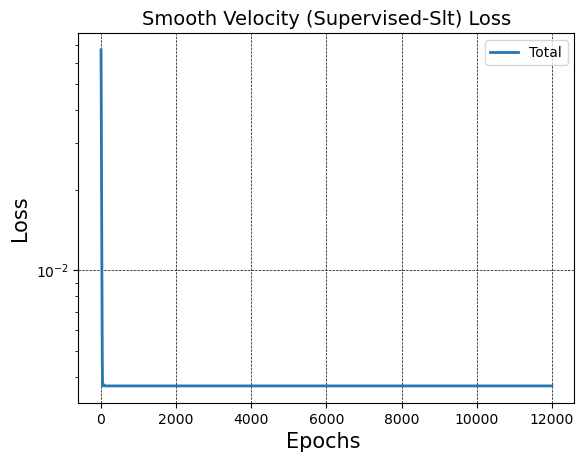

In [34]:
# Plotting the Loss Curve
plt.semilogy(loss_value, label="Total", linewidth=2) # Plots the total loss

plt.title("Smooth Velocity (Supervised-Slt) Loss", fontsize=14)   # Sets the title of the figure

plt.xlabel("Epochs ", fontsize=15)              # Sets the x-axis label of the figure
plt.ylabel("Loss", fontsize=15,)                # Sets the y-axis label of the figure

plt.grid(color = 'black', linestyle = '--', linewidth = 0.5) # Sets the grid of the figure

plt.legend(loc="upper right")   # Sets the legend of the figure

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Smooth Velocity (Supervised-Slt) Loss.pdf", format="pdf", bbox_inches="tight") # Saves the figure

plt.show() # Displays the figure

In [35]:
# Predicts tau output
tau_pred = tau(params,X_star[0].reshape(-1,1),X_star[1].reshape(-1,1))
T_pred =tau_pred*T0.reshape(-1,1)

In [36]:
#Maximum absolute difference between tau predicted and tau analytical
diff = jnp.abs(T_pred-T_data.reshape(-1,1))
jnp.max(diff)

Array(0.06201959, dtype=float32)

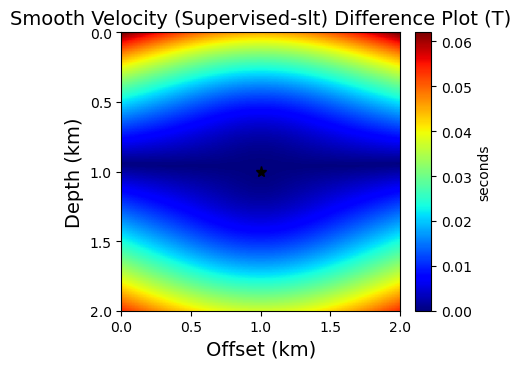

In [37]:
# T predicted and T analytical difference plot

plt.style.use('default')         # Sets the default style for the plot

plt.figure(figsize=(4,4))        # Creates a new figure with a size of 4x4 inches

plt.title("Smooth Velocity (Supervised-slt) Difference Plot (T)", fontsize=14)    # Sets the title of the figure

ax = plt.gca()                   # Gets the current axes instance

im = ax.imshow(jnp.abs(T_pred.reshape(101,101)-T_data), extent=[x_min,x_max,z_max,z_min], aspect=1, cmap="jet")# Plots the velocity model velmodel as an image on the current axes (ax)

ax.plot(sx,sz,'k*',markersize=8) # Plots a black star marker at the source location 

plt.xlabel('Offset (km)', fontsize=14)     # Sets the label for the x-axis
plt.xticks(fontsize=10)          # Sets the font size for the x-axis tick labels

plt.ylabel('Depth (km)', fontsize=14)      # Sets the label for the y-axis
plt.yticks(fontsize=10)          # Sets the font size for the y-axis tick labels

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the major tick locator for the x-axis to have ticks at intervals of 0.5.
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the major tick locator for the y-axis to have ticks at intervals of 0.5.

divider = make_axes_locatable(ax)         # Creates a divider to make room for the colorbar
cax = divider.append_axes("right", size="6%", pad=0.15) # Appends an axes on the right side of the plot to accommodate the colorbar

cbar = plt.colorbar(im, cax=cax) # Adds a colorbar to the plot using the image im and the colorbar axes cax

cbar.set_label('seconds',size=10)   # Sets the label for the colorbar.
cbar.ax.tick_params(labelsize=10)        # Sets the font size of the colorbar tick labels.

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Smooth Velocity (Supervised-slt) Difference Plot (T_1).pdf", format= "pdf",bbox_inches="tight")  # Saves the image as a pdf file at the specified file directory

plt.show()   # Displays the defined image

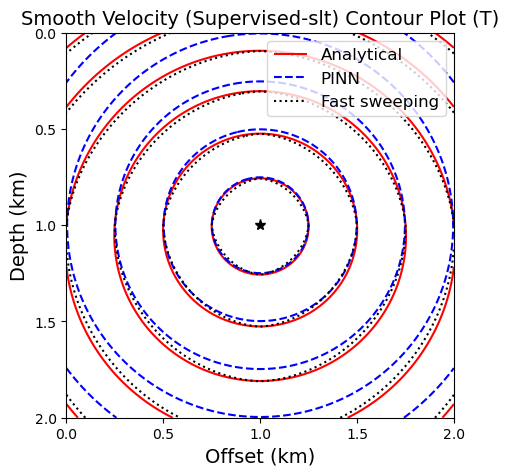

In [38]:
# Traveltime contour plots

plt.figure(figsize=(5,5)) # Creates a new figure with a size of 5x5 inches

ax = plt.gca()      # Gets the current axes instance

plt.title("Smooth Velocity (Supervised-slt) Contour Plot (T)", fontsize=14)    # Sets the title of the figure

# Plots the contours of the difference T values as an image
im1 = ax.contour(T_data.reshape(101,101), 6, extent=[x_min,x_max,z_min,z_max], colors='r')
im2 = ax.contour(T_pred.reshape(101,101), 6, extent=[x_min,x_max,z_min,z_max], colors='b',linestyles = 'dashed')
im3 = ax.contour(T_fsm.reshape(101,101), 6, extent=[x_min,x_max,z_min,z_max], colors='k',linestyles = 'dotted')


ax.plot(sx,sz,'k*',markersize=8) # Plots a black star marker at the source location 

plt.xlabel('Offset (km)', fontsize=14)   # Sets the x-axis label
plt.ylabel('Depth (km)', fontsize=14)    # Sets the y-axis label

ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()

# Sets im1 legend
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()

ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'PINN', 'Fast sweeping'],fontsize=12)  # Sets the combined legend

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the x-axis
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))   # Sets the y-axis

plt.xticks(fontsize=10)   # Sets the x-axis ticks
plt.yticks(fontsize=10)   # Sets the y-axis ticks

plt.savefig("/home/archibong/Desktop/PINNs/Jax/Archibong1/PINNEik Using Jax/Images/Smooth Velocity (Supervised-slt) Contour Plot (T).pdf", format="pdf", bbox_inches="tight")

plt.show()

In [39]:
# Determining the accuracy of the model by quantifying the difference between T_pred and T_data using Vector Norm
print(jnp.linalg.norm(T_pred-T_data.reshape(-1,1))/jnp.linalg.norm(T_data))
print(jnp.linalg.norm(T_pred-T_data.reshape(-1,1)))

0.06941004
2.3310316
